<img align="right" style="max-width: 200px; height: auto" src="cfds_logo.png">

###  Lab 15 - "Long Short-Term Memory (LSTM) Neural Networks (Many to One)"

Chartered Financial Data Scientist (CFDS), Autumn Term 2020/21

In this lab, we will learn how to enhance the previous **"one-to-one"** Long Short-Term Memory (LSTM) neural network training setup towards a **"many-to-one"** training setup. This will allow a model to learn from a set of input time series such as the underlying constituents of an Exchange Traded Fund (ETF). In general, such a "many-to-one" training setup provides the ability to learn complex pattern across multiple input data sources.


We will again use the functionality of the **PyTorch** library to implement and train an LSTM based neural network. The network will be trained on the historic daily (in-sample) returns of an exemplary financial stock. Once the network is trained, we will use the learned model to predict future (out-of-sample) returns. Finally, we will convert the predictions into tradable signals and the backtest the signals accordingly. 

The figure below illustrates a high-level view on the machine learning process we aim to establish in this lab.

<img align="center" style="max-width: 700px" src="process.png">

### Lab Objectives:

After today's lab, you should be able to:

> 1. Understand the basic concepts, intuitions and major building blocks of **Long Short-Term Memory (LSTM) Neural Networks**.
> 2. Know how to **implement and to train a many-to-one LSTM** model of financial time-series data.
> 3. Understand how to apply such a learned model to **predict future data points of a time-series**.
> 4. Know how to **interpret the model's prediction results** and backtest the predictions. 

As always, pls. don't hesitate to ask all your questions either during the lab, post them in our NextThought lab discussion forum (https://financial-data-science.nextthought.io), or send us an email (using our fds.ai email addresses).

Before we start let's watch a motivational video:

In [1]:
from IPython.display import YouTubeVideo
# Nvidia GTC 2016: "The Deep Learning Revolution" Opening in Keynote"
# YouTubeVideo('Dy0hJWltsyE', width=800, height=400)

### Setup of the Jupyter Notebook Environment

Suppress potential warnings:

In [2]:
import warnings
warnings.filterwarnings('ignore')

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will mostly use the `PyTorch`, `Numpy`, `Sklearn`, `Matplotlib`, `Seaborn`, `BT` and a few utility libraries throughout the lab:

In [3]:
# import python data science and utility libraries
import os, sys, itertools, urllib, io
import datetime as dt
import pandas as pd
import pandas_datareader as dr
import numpy as np

Install the Python `BT` backtesting library:

In [4]:
!pip install bt

/bin/bash: pip: command not found


Import the backtesting library:

In [5]:
import bt as bt # library to backtest trading signals

Import the Python machine / deep learning libraries:

In [6]:
# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
from torch.utils.data import dataloader

Import Python plotting libraries and set general plotting parameters:

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi']= 150

Enable notebook matplotlib inline plotting:

In [8]:
%matplotlib inline

Create notebook folder structure to store the data, the visuals, as well as the trained neural network models:

In [9]:
# create data sub-directory inside the current directory
data_directory = './data'
if not os.path.exists(data_directory): os.makedirs(data_directory)
    
# create visuals sub-directory inside the current directory
visuals_directory = './visuals'
if not os.path.exists(visuals_directory): os.makedirs(visuals_directory)

# create models sub-directory inside the current directory
models_directory = './models'
if not os.path.exists(models_directory): os.makedirs(models_directory)
    
# create statistics sub-directory inside the current directory
statistics_directory = './statistics'
if not os.path.exists(statistics_directory): os.makedirs(statistics_directory)

Set random seed value to obtain reproducable results:

In [10]:
# init deterministic seed
seed_value = 1234
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value); # set pytorch seed CPU

Enable GPU computing by setting the `device` flag and init a `CUDA` seed:

In [11]:
# set cpu or gpu enabled device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu').type

# init deterministic GPU seed
torch.cuda.manual_seed(seed_value)

# log type of device enabled
now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] notebook with \'{}\' computation enabled'.format(str(now), str(device)))

[LOG 20210201-08:13:50] notebook with 'cpu' computation enabled


### 1. Data Download

In this section of the lab notebook we will download and access historic daily stock market data ranging from **01/01/2010** to **31/12/2019** of the **"Invesco QQQ ETF"** (ticker symbol: "QQQ") that tracks the NASDAQ-100 index. Thereby, we will utilize the `datareader` of the `Pandas` library that provides the ability to interface the `Yahoo` finance API.

#### 1.1 Target Data Download

To start the data download, let's specify the start and end date of the stock market data download:

In [12]:
start_date = dt.datetime(2010, 1, 1)
end_date = dt.datetime(2019, 12, 31)

Download the daily **"Invesco QQQ ETF"** (QQQ) market data:

In [13]:
stock_data_price = dr.data.DataReader('QQQ', data_source='yahoo', start=start_date, end=end_date)

Inspect the top 10 records of the QQQ market data:

In [14]:
stock_data_price.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,46.490002,46.270000,46.330002,46.419998,62822800.0,41.570904
2010-01-05,46.500000,46.160000,46.389999,46.419998,62935600.0,41.570904
2010-01-06,46.549999,46.070000,46.400002,46.139999,96033000.0,41.320183
2010-01-07,46.270000,45.919998,46.209999,46.169998,77094100.0,41.347046
2010-01-08,46.549999,45.930000,46.070000,46.549999,88886600.0,41.687347
2010-01-11,46.639999,46.119999,46.610001,46.360001,104673400.0,41.517189
2010-01-12,46.139999,45.529999,46.080002,45.779999,90673900.0,40.997784
2010-01-13,46.490002,45.610001,45.919998,46.349998,100661000.0,41.508217
2010-01-14,46.520000,46.220001,46.259998,46.389999,75209000.0,41.544056


Let's also evaluate the data quality of the download by creating a set of summary statistics of the retrieved data:

In [15]:
stock_data_price.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000
mean,105.992186,104.721065,105.395159,105.411900,4.304795e+07,100.945946
std,45.939080,45.438740,45.706718,45.712880,2.759478e+07,46.693583
min,42.820000,41.770000,42.660000,42.470001,7.079300e+06,38.167866
25%,65.227503,64.537500,64.877499,64.927500,2.490798e+07,59.483350
50%,102.630001,100.939999,101.975002,101.730000,3.512575e+07,96.858166
75%,141.607498,140.577507,141.197502,141.092503,5.285995e+07,137.272736
max,214.559998,213.039993,214.539993,213.789993,2.882004e+08,212.579697


Visually inspect the daily closing prices of the QQQ market data:

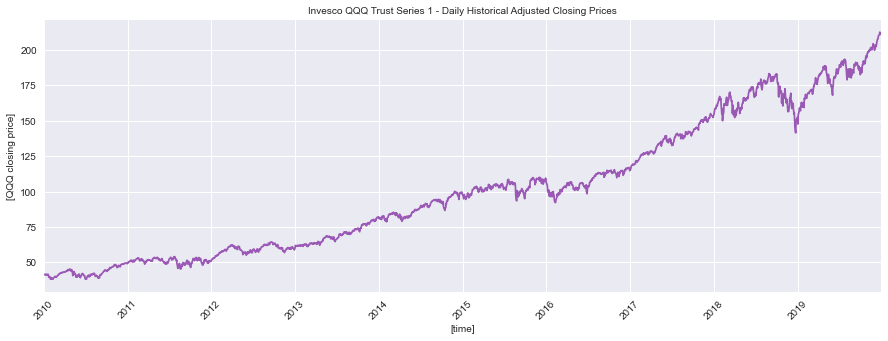

In [16]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot daily adjusted closing price
ax.plot(stock_data_price.index, stock_data_price['Adj Close'], color='#9b59b6')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set x-axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2010'), pd.to_datetime('31-12-2019')])

# set y-axis labels and limits
ax.set_ylabel('[QQQ closing price]', fontsize=10)

# set plot title
plt.title('Invesco QQQ Trust Series 1 - Daily Historical Adjusted Closing Prices', fontsize=10);

Initialize the stock data `Pandas` dataframe by only keeping the **daily adjusted closing price** of the QQQ:

In [17]:
# remove all columns other than the adjusted closing price
stock_data_price = stock_data_price.drop(columns=['High', 'Open', 'Low', 'Close', 'Volume'])

Rename the adjusted closing price column according to the QQQ: 

In [18]:
stock_data_price = stock_data_price.rename(columns={'Adj Close': "QQQ"})

#### 1.2 Input Data Download

Define ticker symbols of the top NASDAQ constituents to be retrieved from the `Yahoo` finance API:

In [19]:
symbols = ['MU', 'ISRG', 'TMUS', 'CME', 'ADP', 'INTU', 'BKNG', 'FISV', 'MDLZ', 'GILD', 'QCOM', 'SBUX', 'CHTR', 'TXN', 'AVGO', 'COST', 'PYPL', 'NFLX', 'NVDA', 'ADBE', 'PEP', 'CMCSA', 'CSCO', 'INTC', 'GOOGL', 'AMZN', 'AAPL', 'MSFT']

Determine and print the number of defined NASDAQ constituents ticker symbols:

In [20]:
# determine number of input stock ticker symbols
no_input_stocks = len(symbols)

# print number of input stock ticker symboks
no_input_stocks

28

Iteratively download the **daily adjusted closing price data** of the defined NASDAQ constituents. Once downloaded we will add them to the stock data `Pandas` dataframe containing the QQQ market data that we initialized above:

In [21]:
# iterate over distinct ticker symbols
for symbol in symbols:
    
    # retrieve market data of current ticker symbol
    symbol_data = dr.data.DataReader(symbol, data_source='yahoo', start=start_date, end=end_date)
    
    # collect the adjusted daily closing price of current ticker symbol
    stock_data_price[symbol] = symbol_data['Adj Close']

Inspect the first 10 rows of the retrieved NASDAQ constituents daily adjusted closing price data:

In [22]:
stock_data_price.head(10)

,QQQ,MU,ISRG,TMUS,CME,ADP,INTU,BKNG,FISV,MDLZ,...,NVDA,ADBE,PEP,CMCSA,CSCO,INTC,GOOGL,AMZN,AAPL,MSFT
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,41.570904,10.85,102.923332,13.207044,44.038776,28.546648,28.015366,223.960007,12.3575,14.167932,...,16.999943,37.090000,44.292305,6.894205,18.463966,14.954695,313.688690,133.899994,6.593423,24.105360
2010-01-05,41.570904,11.17,102.459999,13.240186,44.002773,28.393362,28.015366,226.559998,12.4100,14.860062,...,17.248186,37.700001,44.827515,6.800767,18.381708,14.947535,312.307312,134.690002,6.604822,24.113148
2010-01-06,41.320183,11.22,103.946671,12.345354,43.704395,28.326714,27.624369,219.080002,12.3575,14.963362,...,17.358511,37.619999,44.379101,6.752012,18.262053,14.897401,304.434448,132.250000,6.499765,23.965164
2010-01-07,41.347046,10.84,103.556664,12.461351,43.758408,28.313377,27.533443,216.130005,12.3000,14.927206,...,17.018332,36.889999,44.097023,6.894205,18.344311,14.754156,297.347351,130.000000,6.487749,23.715933
2010-01-08,41.687347,11.10,102.986664,11.765371,44.927525,28.273378,28.260878,216.210007,12.1625,14.942701,...,17.055109,36.689999,43.952370,6.873890,18.441526,14.918890,301.311310,133.520004,6.530882,23.879499
2010-01-11,41.517189,10.90,103.763336,11.914511,44.918518,28.400021,28.388178,218.910004,12.2275,14.875555,...,16.816057,36.209999,43.901749,6.829206,18.389183,15.004833,300.855865,130.309998,6.473268,23.575750
2010-01-12,40.997784,10.26,101.463333,10.522551,44.007900,28.200068,28.388178,213.979996,12.1200,15.128645,...,16.246025,35.660000,44.516521,6.707326,18.097532,14.761323,295.535522,127.349998,6.399635,23.419973
2010-01-13,41.508217,10.46,102.013336,10.489408,44.144257,28.406679,28.715527,214.300003,12.2225,15.097653,...,16.466686,36.279999,44.878143,6.812954,18.426571,15.011992,293.838837,129.110001,6.489905,23.638054
2010-01-14,41.544056,10.73,102.666664,10.323699,43.953918,28.326714,28.897388,208.770004,12.1875,15.040841,...,16.209249,35.900002,45.420586,6.772330,18.658400,15.384431,295.220215,127.349998,6.452318,24.113148


Save the retrieved NASDAQ constituents daily adjusted closing price data the local data directory:

In [23]:
# define the filename of the data to be saved
filename = 'qqq_nasdaq_30_daily_closing.csv'

# save retrieved data to local data directory
stock_data_price.to_csv(os.path.join(data_directory, filename), sep=';', encoding='utf-8')

### 2. Data Pre-Processing

In this section, we will obtain daily returns of the retrieved daily closing prices. Also, we will convert the time-series of daily returns into a set of sequences $s$ of $n$ time steps respectively. The created sequences will then be used to learn a model using an Long Short-Term Memory neural network.

#### 2.1 Missing Data Padding

Let's always forward propagate the last valid available price information observation to the next available valid price information using the Panda's `reindex()` function. This in order to also obtain market price information of weekend's and holidays: 

In [24]:
# fill weekends and holidays
stock_data_price = stock_data_price.reindex(index=pd.date_range(stock_data_price.index.min(), stock_data_price.index.max()), method='ffill')

Inspect the top padded stock market data records of the QQQ and the underlying NASDAQ Top 28 constituents:

In [25]:
stock_data_price.head(10)

,QQQ,MU,ISRG,TMUS,CME,ADP,INTU,BKNG,FISV,MDLZ,...,NVDA,ADBE,PEP,CMCSA,CSCO,INTC,GOOGL,AMZN,AAPL,MSFT
2010-01-04,41.570904,10.85,102.923332,13.207044,44.038776,28.546648,28.015366,223.960007,12.3575,14.167932,...,16.999943,37.090000,44.292305,6.894205,18.463966,14.954695,313.688690,133.899994,6.593423,24.105360
2010-01-05,41.570904,11.17,102.459999,13.240186,44.002773,28.393362,28.015366,226.559998,12.4100,14.860062,...,17.248186,37.700001,44.827515,6.800767,18.381708,14.947535,312.307312,134.690002,6.604822,24.113148
2010-01-06,41.320183,11.22,103.946671,12.345354,43.704395,28.326714,27.624369,219.080002,12.3575,14.963362,...,17.358511,37.619999,44.379101,6.752012,18.262053,14.897401,304.434448,132.250000,6.499765,23.965164
2010-01-07,41.347046,10.84,103.556664,12.461351,43.758408,28.313377,27.533443,216.130005,12.3000,14.927206,...,17.018332,36.889999,44.097023,6.894205,18.344311,14.754156,297.347351,130.000000,6.487749,23.715933
2010-01-08,41.687347,11.10,102.986664,11.765371,44.927525,28.273378,28.260878,216.210007,12.1625,14.942701,...,17.055109,36.689999,43.952370,6.873890,18.441526,14.918890,301.311310,133.520004,6.530882,23.879499
2010-01-09,41.687347,11.10,102.986664,11.765371,44.927525,28.273378,28.260878,216.210007,12.1625,14.942701,...,17.055109,36.689999,43.952370,6.873890,18.441526,14.918890,301.311310,133.520004,6.530882,23.879499
2010-01-10,41.687347,11.10,102.986664,11.765371,44.927525,28.273378,28.260878,216.210007,12.1625,14.942701,...,17.055109,36.689999,43.952370,6.873890,18.441526,14.918890,301.311310,133.520004,6.530882,23.879499
2010-01-11,41.517189,10.90,103.763336,11.914511,44.918518,28.400021,28.388178,218.910004,12.2275,14.875555,...,16.816057,36.209999,43.901749,6.829206,18.389183,15.004833,300.855865,130.309998,6.473268,23.575750
2010-01-12,40.997784,10.26,101.463333,10.522551,44.007900,28.200068,28.388178,213.979996,12.1200,15.128645,...,16.246025,35.660000,44.516521,6.707326,18.097532,14.761323,295.535522,127.349998,6.399635,23.419973
2010-01-13,41.508217,10.46,102.013336,10.489408,44.144257,28.406679,28.715527,214.300003,12.2225,15.097653,...,16.466686,36.279999,44.878143,6.812954,18.426571,15.011992,293.838837,129.110001,6.489905,23.638054


Also inspect the bottom padded stock market data of the QQQ and the underlying NASDAQ Top 28 constituents:

In [26]:
stock_data_price.tail(10)

,QQQ,MU,ISRG,TMUS,CME,ADP,INTU,BKNG,FISV,MDLZ,...,NVDA,ADBE,PEP,CMCSA,CSCO,INTC,GOOGL,AMZN,AAPL,MSFT
2019-12-22,210.056091,55.060001,591.309998,77.400002,193.713379,167.027359,264.660400,2023.260010,116.669998,53.881664,...,238.975662,327.609985,134.014557,42.926853,45.504459,57.519756,1351.219971,1786.500000,69.261856,155.759949
2019-12-23,210.610901,55.400002,597.419983,76.959999,194.440323,165.982773,263.847900,2032.099976,116.330002,53.230022,...,238.426590,328.950012,133.159470,42.936588,46.127808,57.792961,1350.630005,1793.000000,70.392090,155.759949
2019-12-24,210.720291,55.419998,598.809998,77.320000,194.516861,165.875381,261.915680,2044.000000,116.629997,53.482903,...,238.226913,329.640015,133.013718,43.355247,45.820923,57.968597,1344.430054,1789.209961,70.459007,155.730255
2019-12-25,210.720291,55.419998,598.809998,77.320000,194.516861,165.875381,261.915680,2044.000000,116.629997,53.482903,...,238.226913,329.640015,133.013718,43.355247,45.820923,57.968597,1344.430054,1789.209961,70.459007,155.730255
2019-12-26,212.579697,55.110001,598.039978,77.400002,194.991379,166.304932,264.432495,2064.320068,116.029999,53.346733,...,238.795975,331.200012,132.819397,43.783646,45.888054,58.368649,1362.469971,1868.770020,71.856941,157.006729
2019-12-27,212.400726,54.029999,597.880005,77.239998,196.376221,166.714981,264.620789,2072.540039,117.080002,53.764946,...,236.479767,330.790009,133.645325,43.910213,45.811337,58.622341,1354.640015,1869.800049,71.829674,157.293686
2019-12-28,212.400726,54.029999,597.880005,77.239998,196.376221,166.714981,264.620789,2072.540039,117.080002,53.764946,...,236.479767,330.790009,133.645325,43.910213,45.811337,58.622341,1354.640015,1869.800049,71.829674,157.293686
2019-12-29,212.400726,54.029999,597.880005,77.239998,196.376221,166.714981,264.620789,2072.540039,117.080002,53.764946,...,236.479767,330.790009,133.645325,43.910213,45.811337,58.622341,1354.640015,1869.800049,71.829674,157.293686
2019-12-30,211.008652,53.209999,591.320007,78.080002,192.889893,165.562988,260.439331,2053.870117,115.470001,53.769836,...,231.937271,328.339996,132.935989,43.988098,45.638714,58.173500,1339.709961,1846.890015,72.255997,155.938049
2019-12-31,211.406387,53.779999,591.150024,78.419998,194.381256,166.451370,259.537659,2053.729980,115.629997,53.848053,...,234.912384,329.809998,132.799957,43.783646,45.993546,58.397919,1339.390015,1847.839966,72.783936,156.046890


Inspect the number of records obtained after the data padding:

In [27]:
stock_data_price.shape

(3649, 29)

#### 2.2 Daily Log-Return Calculation

Determine the daily returns of the QQQ's daily adjusted closing prices using the `pct_change()` function of the `Pandas` library:

In [28]:
# create deep copy of stock price data
stock_data_return = stock_data_price.copy(deep=True)

# compute the log of the QQQ's daily adjusted closing prices
stock_data_return['QQQ'] = np.log(stock_data_return['QQQ'])

# determine daily log-returns based of the QQQ's daily adjusted closing prices
stock_data_return['QQQ'] = stock_data_return['QQQ'].pct_change()

Inspect the daily returns of the adjusted closing prices:

In [29]:
stock_data_return.head(10)

,QQQ,MU,ISRG,TMUS,CME,ADP,INTU,BKNG,FISV,MDLZ,...,NVDA,ADBE,PEP,CMCSA,CSCO,INTC,GOOGL,AMZN,AAPL,MSFT
2010-01-04,NaN,10.85,102.923332,13.207044,44.038776,28.546648,28.015366,223.960007,12.3575,14.167932,...,16.999943,37.090000,44.292305,6.894205,18.463966,14.954695,313.688690,133.899994,6.593423,24.105360
2010-01-05,0.000000,11.17,102.459999,13.240186,44.002773,28.393362,28.015366,226.559998,12.4100,14.860062,...,17.248186,37.700001,44.827515,6.800767,18.381708,14.947535,312.307312,134.690002,6.604822,24.113148
2010-01-06,-0.001623,11.22,103.946671,12.345354,43.704395,28.326714,27.624369,219.080002,12.3575,14.963362,...,17.358511,37.619999,44.379101,6.752012,18.262053,14.897401,304.434448,132.250000,6.499765,23.965164
2010-01-07,0.000175,10.84,103.556664,12.461351,43.758408,28.313377,27.533443,216.130005,12.3000,14.927206,...,17.018332,36.889999,44.097023,6.894205,18.344311,14.754156,297.347351,130.000000,6.487749,23.715933
2010-01-08,0.002202,11.10,102.986664,11.765371,44.927525,28.273378,28.260878,216.210007,12.1625,14.942701,...,17.055109,36.689999,43.952370,6.873890,18.441526,14.918890,301.311310,133.520004,6.530882,23.879499
2010-01-09,0.000000,11.10,102.986664,11.765371,44.927525,28.273378,28.260878,216.210007,12.1625,14.942701,...,17.055109,36.689999,43.952370,6.873890,18.441526,14.918890,301.311310,133.520004,6.530882,23.879499
2010-01-10,0.000000,11.10,102.986664,11.765371,44.927525,28.273378,28.260878,216.210007,12.1625,14.942701,...,17.055109,36.689999,43.952370,6.873890,18.441526,14.918890,301.311310,133.520004,6.530882,23.879499
2010-01-11,-0.001096,10.90,103.763336,11.914511,44.918518,28.400021,28.388178,218.910004,12.2275,14.875555,...,16.816057,36.209999,43.901749,6.829206,18.389183,15.004833,300.855865,130.309998,6.473268,23.575750
2010-01-12,-0.003379,10.26,101.463333,10.522551,44.007900,28.200068,28.388178,213.979996,12.1200,15.128645,...,16.246025,35.660000,44.516521,6.707326,18.097532,14.761323,295.535522,127.349998,6.399635,23.419973
2010-01-13,0.003332,10.46,102.013336,10.489408,44.144257,28.406679,28.715527,214.300003,12.2225,15.097653,...,16.466686,36.279999,44.878143,6.812954,18.426571,15.011992,293.838837,129.110001,6.489905,23.638054


Visually inspect the obtained daily adjusted returns:

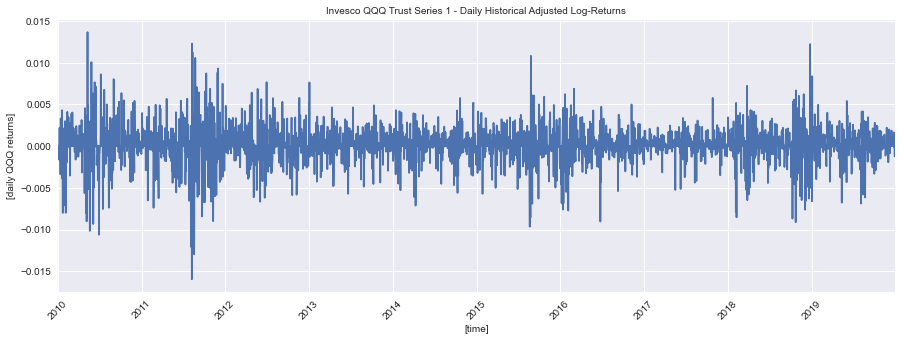

In [30]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot daily market returns
ax.plot(stock_data_return.index, stock_data_return['QQQ'])

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2010'), pd.to_datetime('31-12-2019')])
ax.set_ylabel('[daily QQQ returns]', fontsize=10)

# set plot title
plt.title('Invesco QQQ Trust Series 1 - Daily Historical Adjusted Log-Returns', fontsize=10);

Determine the daily returns of the remaining NASDAQ Top 30 daily adjusted closing prices using the `pct_change()` function of the `Pandas` library:

In [31]:
# iterate over distinct ticker symbols
for symbol in symbols:
    
    # compute the log of the ticker symbols daily adjusted closing prices
    stock_data_return[symbol] = np.log(stock_data_return[symbol]) 
    
    # determine daily log-returns based of the ticker symbol daily adjusted closing prices
    stock_data_return[symbol] = stock_data_return[symbol].pct_change()

Inspect the daily returns of the adjusted closing prices:

In [32]:
stock_data_return.head(10)

,QQQ,MU,ISRG,TMUS,CME,ADP,INTU,BKNG,FISV,MDLZ,...,NVDA,ADBE,PEP,CMCSA,CSCO,INTC,GOOGL,AMZN,AAPL,MSFT
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.000000,0.012191,-0.000974,0.000971,-0.000216,-0.001606,0.000000,0.002133,0.001686,0.017992,...,0.005117,0.004515,0.003168,-0.007068,-0.001531,-0.000177,-0.000768,0.001201,0.000916,0.000102
2010-01-06,-0.001623,0.001851,0.003112,-0.027089,-0.001798,-0.000702,-0.004217,-0.006191,-0.001683,0.002567,...,0.002239,-0.000585,-0.002644,-0.003753,-0.002243,-0.001242,-0.004445,-0.003729,-0.008493,-0.001934
2010-01-07,0.000175,-0.014251,-0.000809,0.003721,0.000327,-0.000141,-0.000993,-0.002515,-0.001855,-0.000894,...,-0.006935,-0.005402,-0.001681,0.010912,0.001547,-0.003577,-0.004119,-0.003513,-0.000989,-0.003291
2010-01-08,0.002202,0.009945,-0.001190,-0.022782,0.006978,-0.000423,0.007865,0.000069,-0.004480,0.000384,...,0.000762,-0.001507,-0.000868,-0.001528,0.001817,0.004125,0.002325,0.005489,0.003544,0.002171
2010-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-11,-0.001096,-0.007554,0.001621,0.005110,-0.000053,0.001337,0.001345,0.002308,0.002133,-0.001665,...,-0.004976,-0.003655,-0.000305,-0.003383,-0.000975,0.002125,-0.000265,-0.004972,-0.004722,-0.004035
2010-01-12,-0.003379,-0.025331,-0.004829,-0.050141,-0.005383,-0.002111,0.000000,-0.004227,-0.003527,0.006249,...,-0.012219,-0.004264,0.003677,-0.009373,-0.005490,-0.006041,-0.003127,-0.004718,-0.006125,-0.002098
2010-01-13,0.003332,0.008292,0.001170,-0.001340,0.000817,0.002186,0.003427,0.000278,0.003376,-0.000755,...,0.004839,0.004823,0.002131,0.008210,0.006222,0.006255,-0.001012,0.002832,0.007546,0.002939


Remove the first row corresponding to a `nan` daily return of the stock data dataframe: 

In [33]:
stock_data_return = stock_data_return.iloc[1:]

Inspect the daily returns of the adjusted closing prices for the removed row:

In [34]:
stock_data_return.head(10)

,QQQ,MU,ISRG,TMUS,CME,ADP,INTU,BKNG,FISV,MDLZ,...,NVDA,ADBE,PEP,CMCSA,CSCO,INTC,GOOGL,AMZN,AAPL,MSFT
2010-01-05,0.000000,0.012191,-0.000974,0.000971,-0.000216,-0.001606,0.000000,0.002133,0.001686,0.017992,...,0.005117,0.004515,0.003168,-0.007068,-0.001531,-0.000177,-0.000768,0.001201,0.000916,0.000102
2010-01-06,-0.001623,0.001851,0.003112,-0.027089,-0.001798,-0.000702,-0.004217,-0.006191,-0.001683,0.002567,...,0.002239,-0.000585,-0.002644,-0.003753,-0.002243,-0.001242,-0.004445,-0.003729,-0.008493,-0.001934
2010-01-07,0.000175,-0.014251,-0.000809,0.003721,0.000327,-0.000141,-0.000993,-0.002515,-0.001855,-0.000894,...,-0.006935,-0.005402,-0.001681,0.010912,0.001547,-0.003577,-0.004119,-0.003513,-0.000989,-0.003291
2010-01-08,0.002202,0.009945,-0.001190,-0.022782,0.006978,-0.000423,0.007865,0.000069,-0.004480,0.000384,...,0.000762,-0.001507,-0.000868,-0.001528,0.001817,0.004125,0.002325,0.005489,0.003544,0.002171
2010-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-11,-0.001096,-0.007554,0.001621,0.005110,-0.000053,0.001337,0.001345,0.002308,0.002133,-0.001665,...,-0.004976,-0.003655,-0.000305,-0.003383,-0.000975,0.002125,-0.000265,-0.004972,-0.004722,-0.004035
2010-01-12,-0.003379,-0.025331,-0.004829,-0.050141,-0.005383,-0.002111,0.000000,-0.004227,-0.003527,0.006249,...,-0.012219,-0.004264,0.003677,-0.009373,-0.005490,-0.006041,-0.003127,-0.004718,-0.006125,-0.002098
2010-01-13,0.003332,0.008292,0.001170,-0.001340,0.000817,0.002186,0.003427,0.000278,0.003376,-0.000755,...,0.004839,0.004823,0.002131,0.008210,0.006222,0.006255,-0.001012,0.002832,0.007546,0.002939
2010-01-14,0.000232,0.010856,0.001380,-0.006775,-0.001141,-0.000842,0.001880,-0.004871,-0.001146,-0.001389,...,-0.005625,-0.002932,0.003158,-0.003117,0.004291,0.009047,0.000825,-0.002824,-0.003106,0.006292


Replace potential missing values `nan` or infinity values (division by zero) `inf` with 0.0:

In [35]:
stock_data_return = stock_data_return.replace([np.nan, np.inf, -np.inf], 0.0)

Inspect the daily returns of the adjusted closing prices for the replaced values:

In [36]:
stock_data_return.head(10)

,QQQ,MU,ISRG,TMUS,CME,ADP,INTU,BKNG,FISV,MDLZ,...,NVDA,ADBE,PEP,CMCSA,CSCO,INTC,GOOGL,AMZN,AAPL,MSFT
2010-01-05,0.000000,0.012191,-0.000974,0.000971,-0.000216,-0.001606,0.000000,0.002133,0.001686,0.017992,...,0.005117,0.004515,0.003168,-0.007068,-0.001531,-0.000177,-0.000768,0.001201,0.000916,0.000102
2010-01-06,-0.001623,0.001851,0.003112,-0.027089,-0.001798,-0.000702,-0.004217,-0.006191,-0.001683,0.002567,...,0.002239,-0.000585,-0.002644,-0.003753,-0.002243,-0.001242,-0.004445,-0.003729,-0.008493,-0.001934
2010-01-07,0.000175,-0.014251,-0.000809,0.003721,0.000327,-0.000141,-0.000993,-0.002515,-0.001855,-0.000894,...,-0.006935,-0.005402,-0.001681,0.010912,0.001547,-0.003577,-0.004119,-0.003513,-0.000989,-0.003291
2010-01-08,0.002202,0.009945,-0.001190,-0.022782,0.006978,-0.000423,0.007865,0.000069,-0.004480,0.000384,...,0.000762,-0.001507,-0.000868,-0.001528,0.001817,0.004125,0.002325,0.005489,0.003544,0.002171
2010-01-09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-11,-0.001096,-0.007554,0.001621,0.005110,-0.000053,0.001337,0.001345,0.002308,0.002133,-0.001665,...,-0.004976,-0.003655,-0.000305,-0.003383,-0.000975,0.002125,-0.000265,-0.004972,-0.004722,-0.004035
2010-01-12,-0.003379,-0.025331,-0.004829,-0.050141,-0.005383,-0.002111,0.000000,-0.004227,-0.003527,0.006249,...,-0.012219,-0.004264,0.003677,-0.009373,-0.005490,-0.006041,-0.003127,-0.004718,-0.006125,-0.002098
2010-01-13,0.003332,0.008292,0.001170,-0.001340,0.000817,0.002186,0.003427,0.000278,0.003376,-0.000755,...,0.004839,0.004823,0.002131,0.008210,0.006222,0.006255,-0.001012,0.002832,0.007546,0.002939
2010-01-14,0.000232,0.010856,0.001380,-0.006775,-0.001141,-0.000842,0.001880,-0.004871,-0.001146,-0.001389,...,-0.005625,-0.002932,0.003158,-0.003117,0.004291,0.009047,0.000825,-0.002824,-0.003106,0.006292


Save the obtained and validated daily return stock market data to the local data directory:

In [37]:
# define the filename of the data to be saved
filename = 'qqq_nasdaq_30_daily_returns.csv'

# save retrieved data to local data directory
stock_data_return.to_csv(os.path.join(data_directory, filename), sep=';', encoding='utf-8')

#### 2.3 Train-Validation Data Split

To understand and evaluate the performance of any trained **supervised machine learning** model, it is good practice, to divide the dataset into a **training set** or **"in-sample"** data (the fraction of data records solely used for training purposes) and a **evaluation set** or **"out-of-sample"** data (the fraction of data records solely used for evaluation purposes). Pls. note, the **evaluation set** will never be shown to the model as part of the training process.

<img align="center" style="max-width: 500px" src="traintestsplit.png">

We set the split fraction of training sequences to **90%** of the total number of obtained sequences:

In [38]:
split_fraction = 0.9
split_row = int(stock_data_return.shape[0] * split_fraction)

Split obtained returns into training ("in-sample") returns $r^{i}_{train}$ and validation ("out-of-sample") returns $r^{i}_{valid}$:

In [39]:
train_stock_data_return = stock_data_return.iloc[:split_row]
valid_stock_data_return = stock_data_return.iloc[split_row:]

Visually inspect the obtained train and validation stock returns:

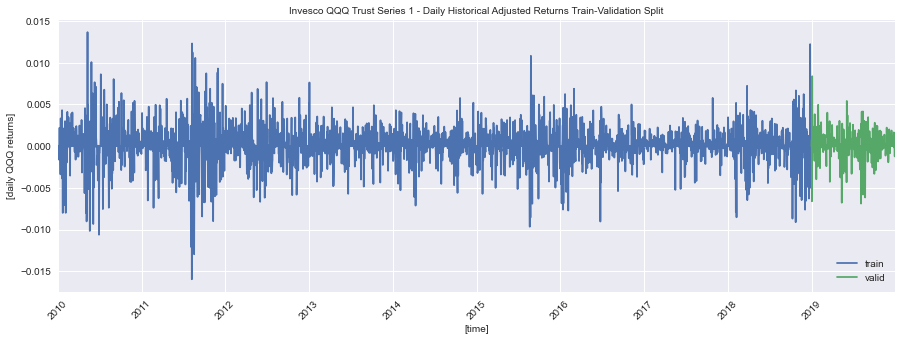

In [40]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot daily training market returns
ax.plot(stock_data_return.index[:split_row,], train_stock_data_return['QQQ'], c='C0', label='train')

# plot daily validation market returns
ax.plot(stock_data_return.index[split_row:,], valid_stock_data_return['QQQ'], c='C1', label='valid')

# rotate x-labels 45 degree angle
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([pd.to_datetime('01-01-2010'), pd.to_datetime('31-12-2019')])
ax.set_ylabel('[daily QQQ returns]', fontsize=10)

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('Invesco QQQ Trust Series 1 - Daily Historical Adjusted Returns Train-Validation Split', fontsize=10);

Determine count (shape) of daily return train sequences $r^{i}_{train}$:

In [41]:
train_stock_data_return.shape

(3283, 29)

Determine count (shape) of daily return train sequences $r^{i}_{valid}$:

In [42]:
valid_stock_data_return.shape

(365, 29)

### 3. Data Sequencing

#### 3.1 Time-Series to Sequence Conversion

In the following, we determine the number of return time-steps $n$ each individual sequence $s^{i}$ should be comprised of. Each sequence is thereby determined by the number of predictor (return) time-steps $t$ and the prediction (return) horizon $h = t+1$.

<img align="center" style="max-width: 500px" src="timesteps.png">

In this example, we will set the number of predictor (return) time-steps to $t$=4. This indicates that the input sequence of each sample is a vector of 4 sequential daily stock returns (pls. note, the choice of $t$=4 is arbitrary and should be selected through experimentation). Furthermore, we set the return horizon to be predicted to 1, which specifies that we aim to forecast a single future time-step:

In [43]:
time_steps = 4 # number of predictor timesteps
horizon = 1 # number of timesteps to be predicted
sequence_length = time_steps + horizon # determine sequence length

Next, we extract sequences $s^i$ of **sequence length: 5 time-steps**. Thereby, we will step-wise iterate ("rolling window") over the entire sequence of daily stock returns $r_i$. In each iteration step, we extract an individual sequence of stock returns consisting of $n$ time-steps. The extracted individual sequences of daily closing prices are then collected in a single data frame.

<img align="center" style="max-width: 900px" src="sequences.png">

#### 3.2 In-Sample Target Log-Returns

Next, we will determine the number of available **rolling training ("in-sample") target sequences**. Remember that each sequence exhibits consists of **a sequence length of 5 time-steps** as defined by the variable `sequence_length` above:

In [44]:
no_train_sequences = train_stock_data_return.shape[0] - sequence_length

Let's now print the number of available rolling training sequences comprised of 5 daily adjusted log-return time-steps each:

In [45]:
no_train_sequences

3278

Initialize a 2D tensor (a 2D array) that contains the target variable we aim to learn to predict as part of the training procedure. The training target corresponds to a **2D tensor of size** `no_train_sequences`$\times$`sequence_length`. The tensor contains the daily adjusted log-returns of the QQQ: 

In [46]:
# init the train sequence target daily returns data 2D matrix
train_stock_sequence_target_data = np.zeros([no_train_sequences, sequence_length])

# init the train sequence target daily dates data 2D matrix
train_stock_sequence_target_date = np.empty([no_train_sequences, sequence_length], dtype='datetime64[s]')

Let's now fill the created 2D tensor with the rolling sequences of the QQQ's daily adjusted log-returns: 

In [47]:
# init the sequence count
j = 0

# iterate over the distinct daily returns of the training dataset
while j < (train_stock_data_return.shape[0] - sequence_length):

    # determine current training sequence returns
    return_sequence = np.array(train_stock_data_return['QQQ'][j:j + sequence_length].T)
    
    # determine current training sequence dates
    date_sequence = np.array(train_stock_data_return.index[j:j + sequence_length].T)
    
    # fill 2D matrix of train stock target sequences with current sequence
    train_stock_sequence_target_data[j, :] = return_sequence
    
    # fill 2D matrix of train stock target sequences with current sequence
    train_stock_sequence_target_date[j, :] = date_sequence
    
    # increase the sequence count
    j += 1

Ultimately, let's inspect the final shape of the filled 2D-array of daily adjusted log-return **target training** sequences:

In [48]:
train_stock_sequence_target_data.shape

(3278, 5)

Also, inspect the **first 10 sequences** of the initialized and filled 2D-array of daily adjusted log-return target training sequences:

In [49]:
train_stock_sequence_target_data[0:10, :]

array([[ 0.        , -0.00162296,  0.00017464,  0.00220223,  0.        ],
       [-0.00162296,  0.00017464,  0.00220223,  0.        ,  0.        ],
       [ 0.00017464,  0.00220223,  0.        ,  0.        , -0.00109649],
       [ 0.00220223,  0.        ,  0.        , -0.00109649, -0.00337873],
       [ 0.        ,  0.        , -0.00109649, -0.00337873,  0.00333199],
       [ 0.        , -0.00109649, -0.00337873,  0.00333199,  0.00023164],
       [-0.00109649, -0.00337873,  0.00333199,  0.00023164, -0.00314184],
       [-0.00337873,  0.00333199,  0.00023164, -0.00314184,  0.        ],
       [ 0.00333199,  0.00023164, -0.00314184,  0.        ,  0.        ],
       [ 0.00023164, -0.00314184,  0.        ,  0.        ,  0.        ]])

And inspect the **last 10 sequences** of the initialized and filled 2D-array of daily adjusted log-return target training sequences:

In [50]:
train_stock_sequence_target_data[-10:-1, :]

array([[-0.00452507,  0.00124323, -0.00492451, -0.0029066 , -0.00628537],
       [ 0.00124323, -0.00492451, -0.0029066 , -0.00628537,  0.        ],
       [-0.00492451, -0.0029066 , -0.00628537,  0.        ,  0.        ],
       [-0.0029066 , -0.00628537,  0.        ,  0.        , -0.00504482],
       [-0.00628537,  0.        ,  0.        , -0.00504482,  0.        ],
       [ 0.        ,  0.        , -0.00504482,  0.        ,  0.01222979],
       [ 0.        , -0.00504482,  0.        ,  0.01222979,  0.00077045],
       [-0.00504482,  0.        ,  0.01222979,  0.00077045, -0.0001042 ],
       [ 0.        ,  0.01222979,  0.00077045, -0.0001042 ,  0.        ]])

#### 3.2 In-Sample Input Log-Returns

Next, we will determine the number of available **rolling training ("in-sample") input sequences**. Remember that each sequence exhibits consists of a a total number of 5 time-steps as defined by the variable `sequence_length` above. However, we will use several NASDAQ constituents as an input. This will add a third dimension to the input data, defined by the variable `no_input_stocks`, we need to consider when preparing the rolling input training sequences. 

Initialize a 3D tensor (a 3D array) that contains the input sequences we aim learn from as part of the training procedure. The training input corresponds to a **3D tensor of size:** `no_train_sequences` $\times$ `sequence_length`$\times$`no_input_stocks`. The tensor contains the daily adjusted log-returns of the distinct NASDAQ constituents: 

In [51]:
# init the train sequence input data 3D matrix
train_stock_sequence_input_data = np.zeros([no_train_sequences, sequence_length, no_input_stocks])

Let's now fill the created 3D tensor with the rolling sequences of the distinct NASDAQ constituents:

In [52]:
# iterate over the distinct ticker symbols
for i in range(0, len(symbols)):

    # init sequence count
    j = 0

    # iterate over the distinct daily returns of the training dataset
    while j < (train_stock_data_return.shape[0] - sequence_length):

        # determine current training sequence
        sequence = np.array(train_stock_data_return[symbols[i]][j:j + sequence_length].T)

        # fill 3D matrix of train stock input sequences with current sequence
        train_stock_sequence_input_data[j, :, i] = sequence

        # increase sequence count
        j += 1

Let's inspect the final shape of the filled 3D-array of daily adjusted log-return **input training** sequences:

In [53]:
train_stock_sequence_input_data.shape

(3278, 5, 28)

In addition, let's inspect the first 10 sequences of the **first constituent** of the filled 3D-array of daily adjusted log-return input training sequences:

In [54]:
train_stock_sequence_input_data[0:10, :, 0]

array([[ 0.01219148,  0.00185076, -0.01425112,  0.00994533,  0.        ],
       [ 0.00185076, -0.01425112,  0.00994533,  0.        ,  0.        ],
       [-0.01425112,  0.00994533,  0.        ,  0.        , -0.00755413],
       [ 0.00994533,  0.        ,  0.        , -0.00755413, -0.02533106],
       [ 0.        ,  0.        , -0.00755413, -0.02533106,  0.00829188],
       [ 0.        , -0.00755413, -0.02533106,  0.00829188,  0.01085598],
       [-0.00755413, -0.02533106,  0.00829188,  0.01085598, -0.02424826],
       [-0.02533106,  0.00829188,  0.01085598, -0.02424826,  0.        ],
       [ 0.00829188,  0.01085598, -0.02424826,  0.        ,  0.        ],
       [ 0.01085598, -0.02424826,  0.        ,  0.        ,  0.        ]])

Also, let's inspect the first 10 sequences of the **last constituent** of the filled 3D-array of daily adjusted log-return input training sequences:

In [55]:
train_stock_sequence_input_data[0:10, :, -1]

array([[ 0.0001015 , -0.00193416, -0.003291  ,  0.00217085,  0.        ],
       [-0.00193416, -0.003291  ,  0.00217085,  0.        ,  0.        ],
       [-0.003291  ,  0.00217085,  0.        ,  0.        , -0.00403454],
       [ 0.00217085,  0.        ,  0.        , -0.00403454, -0.00209778],
       [ 0.        ,  0.        , -0.00403454, -0.00209778,  0.00293908],
       [ 0.        , -0.00403454, -0.00209778,  0.00293908,  0.00629158],
       [-0.00403454, -0.00209778,  0.00293908,  0.00629158, -0.00101648],
       [-0.00209778,  0.00293908,  0.00629158, -0.00101648,  0.        ],
       [ 0.00293908,  0.00629158, -0.00101648,  0.        ,  0.        ],
       [ 0.00629158, -0.00101648,  0.        ,  0.        ,  0.        ]])

#### 3.3 Out-of-Sample Output Log-Returns

Now, we will determine the number of available **rolling validation ("out-of-sample") target sequences**. Remember again that each sequence exhibits consists of a a total number of 5 time-steps as defined by the variable `sequence_length` above:

In [56]:
# determine max valid index
no_valid_sequences = valid_stock_data_return.shape[0] - sequence_length

Let's now print the number of available validation training comprised of 5 daily adjusted log-return time-steps each:

In [57]:
no_valid_sequences

360

Initialize a 2D tensor (a 2D array) that contains the target variable we aimed to learn to predict as part of the training procedure. The validation target corresponds to a **2D tensor of size** `no_valid_sequences`$\times$`sequence_length`. The tensor contains the daily adjusted log-returns of the QQQ: 

In [58]:
# init the valid sequence target daily returns data 2D matrix
valid_stock_sequence_target_data = np.zeros([no_valid_sequences, sequence_length])

# init the valid sequence target daily dates data 2D matrix
valid_stock_sequence_target_date = np.empty([no_valid_sequences, sequence_length], dtype='datetime64[s]')

Let's now again fill the created 2D tensor with the rolling sequences of the QQQ's daily adjusted log-returns: 

In [59]:
# init sequence count
j = 0

# iterate over the distinct daily returns of the validation dataset
while j < (valid_stock_data_return.shape[0] - sequence_length):

    # determine current validation sequence returns
    return_sequence = np.array(valid_stock_data_return['QQQ'][j:j + sequence_length].T)
    
    # determine current validation sequence dates
    date_sequence = np.array(valid_stock_data_return.index[j:j + sequence_length].T)

    # fill 2D matrix of valid stock target sequences with current sequence
    valid_stock_sequence_target_data[j, :] = return_sequence
    
    # fill 2D matrix of valid stock target sequences with current sequence
    valid_stock_sequence_target_date[j, :] = date_sequence

    # increase sequence count
    j += 1

Ultimately, let's inspect the final shape of the filled 2D-array of daily adjusted log-return **target validation** sequences:

In [60]:
valid_stock_sequence_target_data.shape

(360, 5)

Also, inspect the **first 10 sequences** of the initialized and filled 2D-array of daily adjusted log-return target validation sequences:

In [61]:
valid_stock_sequence_target_data[0:10, :]

array([[ 0.        ,  0.00079829, -0.00660517,  0.00838637,  0.        ],
       [ 0.00079829, -0.00660517,  0.00838637,  0.        ,  0.        ],
       [-0.00660517,  0.00838637,  0.        ,  0.        ,  0.00234944],
       [ 0.00838637,  0.        ,  0.        ,  0.00234944,  0.0017834 ],
       [ 0.        ,  0.        ,  0.00234944,  0.0017834 ,  0.0016046 ],
       [ 0.        ,  0.00234944,  0.0017834 ,  0.0016046 ,  0.00056373],
       [ 0.00234944,  0.0017834 ,  0.0016046 ,  0.00056373, -0.00072299],
       [ 0.0017834 ,  0.0016046 ,  0.00056373, -0.00072299,  0.        ],
       [ 0.0016046 ,  0.00056373, -0.00072299,  0.        ,  0.        ],
       [ 0.00056373, -0.00072299,  0.        ,  0.        , -0.00175221]])

And inspect the **last 10 sequences** of the initialized and filled 2D-array of daily adjusted log-return target validation sequences:

In [62]:
valid_stock_sequence_target_data[-10:-1, :]

array([[ 1.07438081e-04,  1.43153408e-04,  1.16767058e-03,
         7.52907572e-04,  0.00000000e+00],
       [ 1.43153408e-04,  1.16767058e-03,  7.52907572e-04,
         0.00000000e+00,  0.00000000e+00],
       [ 1.16767058e-03,  7.52907572e-04,  0.00000000e+00,
         0.00000000e+00,  4.93281862e-04],
       [ 7.52907572e-04,  0.00000000e+00,  0.00000000e+00,
         4.93281862e-04,  9.70577586e-05],
       [ 0.00000000e+00,  0.00000000e+00,  4.93281862e-04,
         9.70577586e-05,  0.00000000e+00],
       [ 0.00000000e+00,  4.93281862e-04,  9.70577586e-05,
         0.00000000e+00,  1.64195675e-03],
       [ 4.93281862e-04,  9.70577586e-05,  0.00000000e+00,
         1.64195675e-03, -1.57156631e-04],
       [ 9.70577586e-05,  0.00000000e+00,  1.64195675e-03,
        -1.57156631e-04,  0.00000000e+00],
       [ 0.00000000e+00,  1.64195675e-03, -1.57156631e-04,
         0.00000000e+00,  0.00000000e+00]])

#### 3.4 Out-of-Sample Input Log-Returns

Following, we will determine the number of available **rolling training ("out-of-sample") input sequences**. Remember that each sequence exhibits consists of a a total number of 5 time-steps as defined by the variable `sequence_length` above. However, we will use several NASDAQ constituents as an input. Again, this will add a third dimension to the input data, defined by the variable `no_input_stocks`, we need to consider when preparing the rolling input validation sequences. 

Initialize a 3D tensor (a 3D array) that contains the input sequences we aim to use in the validation procedure. The validation input corresponds to a **3D tensor of size** `no_valid_sequences` $\times$ `sequence_length`$\times$`no_input_stocks`. The tensor contains the daily adjusted log-returns of the distinct NASDAQ constituents: 

In [63]:
# init the valid sequence input data 3D matrix
valid_stock_sequence_input_data = np.zeros([no_valid_sequences, sequence_length, no_input_stocks])

Let's now fill the created 3D tensor with the rolling sequences of the distinct NASDAQ constituents:

In [64]:
# iterate over distinct ticker symbols
for i in range(0, len(symbols)):

    # init sequence count
    j = 0

    # iterate over the distinct daily returns of the training dataset
    while j < (valid_stock_data_return.shape[0] - sequence_length):

        # determine current training sequence
        sequence = np.array(valid_stock_data_return[symbols[i]][j:j + sequence_length].T)

        # fill 3D matrix of train stock input sequences with current sequence
        valid_stock_sequence_input_data[j, :, i] = sequence

        # increase sequence count
        j += 1

Let's inspect the final shape of the filled 3D-array of daily adjusted log-return **input validation** sequences:

In [65]:
valid_stock_sequence_input_data.shape

(360, 5, 28)

In addition, let's inspect the first 10 sequences of the **first constituent** of the filled 3D-array of daily adjusted log-return input validation sequences:

In [66]:
valid_stock_sequence_input_data[0:10, :, 0]

array([[ 0.        ,  0.00915186, -0.01574012,  0.01554691,  0.        ],
       [ 0.00915186, -0.01574012,  0.01554691,  0.        ,  0.        ],
       [-0.01574012,  0.01554691,  0.        ,  0.        ,  0.01117902],
       [ 0.01554691,  0.        ,  0.        ,  0.01117902, -0.00217686],
       [ 0.        ,  0.        ,  0.01117902, -0.00217686,  0.01397027],
       [ 0.        ,  0.01117902, -0.00217686,  0.01397027,  0.00369263],
       [ 0.01117902, -0.00217686,  0.01397027,  0.00369263,  0.00077655],
       [-0.00217686,  0.01397027,  0.00369263,  0.00077655,  0.        ],
       [ 0.01397027,  0.00369263,  0.00077655,  0.        ,  0.        ],
       [ 0.00369263,  0.00077655,  0.        ,  0.        , -0.01058149]])

Also, let's inspect the first 10 sequences of the **last constituent** of the filled 3D-array of daily adjusted log-return input validation sequences:

In [67]:
valid_stock_sequence_input_data[0:10, :, -1]

array([[ 0.        , -0.00096622, -0.00816401,  0.00998332,  0.        ],
       [-0.00096622, -0.00816401,  0.00998332,  0.        ,  0.        ],
       [-0.00816401,  0.00998332,  0.        ,  0.        ,  0.00027715],
       [ 0.00998332,  0.        ,  0.        ,  0.00027715,  0.0015704 ],
       [ 0.        ,  0.        ,  0.00027715,  0.0015704 ,  0.00308151],
       [ 0.        ,  0.00027715,  0.0015704 ,  0.00308151, -0.00139474],
       [ 0.00027715,  0.0015704 ,  0.00308151, -0.00139474, -0.00167964],
       [ 0.0015704 ,  0.00308151, -0.00139474, -0.00167964,  0.        ],
       [ 0.00308151, -0.00139474, -0.00167964,  0.        ,  0.        ],
       [-0.00139474, -0.00167964,  0.        ,  0.        , -0.00158922]])

### 4. Data Preparation

Before we finalize the data preparation, let's briefly revisit how RNN's or, more specifically, LSTM based NN's can be trained to predict the next element of an input sequence. The cartoon below is derived from the "Next Word Predictor" Example that we also discussed in the course. For each **input return** $r_{i}$ of the input return training sequence $s^i$ the LSTM is supposed to learn to **predict the return** of the next time-step $\hat{r}_{i+1}$. In order to make such a future return $\hat{r}_{i+1}$ prediction the LSTM uses it's learned hidden state information $h_{i}$ as well as the current return $r_{i}$ as an input.

#### 4.1 Input-Target Data Preparation

For each time-step the predicted return $\hat{r}_{i+1}$ is then compared to the **target return** $r_{i+1}$. The discrepancy between both is collected as a loss $\mathcal{L}$ for the distinct timesteps. The accumulation of the individual time-step losses is accumulated as the total loss of a sequence $\mathcal{L}_{All}$.

<img align="center" style="max-width: 600px" src="training.png">

In order to establish the LSTM training setup outlined above each input training sequence $s^{i}_{train}$ is sliced to result in an offset sequence of input-train-sequence return time-steps denoted by $s^{i}_{train, input}=\{r_{1}, ..., r_{t-1}\}$. Furthermore, each target training sequence $s^{i}_{train}$ is sliced to result in an offset sequence of target-train-sequence return time-steps denoted by $s^{i}_{train, target}=\{r_{2}, ..., r_{t}\}$. An example of the applied sequence offset given a sequence length of five time-steps is shown hereafter: 

<img align="center" style="max-width: 800px" src="sequencesplit.png">

Let's now determine the introduced offset of the target training sequences: 

In [68]:
train_sequences_target = train_stock_sequence_target_data[:, 1:]

Check the derived dimensionality of the **target-train-sequences** tensor:

In [69]:
train_sequences_target.shape

(3278, 4)

Also let's determine the introduced offset of the input training sequences: 

In [70]:
train_sequences_input = train_stock_sequence_input_data[:, :-1, :]

Check the derived dimensionality of the **input-train-sequences** tensor:

In [71]:
train_sequences_input.shape

(3278, 4, 28)

In a next step we will likewise process each input validation sequence $s^{i}_{valid}$. The input validation sequences are sliced to also result in offset sequences of input-validation-sequence return time-steps denoted by $s^{i}_{valid, input}=\{r_{1}, ..., r_{t-1}\}$. Furthermore, each target validation sequence $s^{i}_{valid}$ is sliced to result in an offset sequence of target-validation-sequence return time-steps denoted by $s^{i}_{valid, target}=\{r_{2}, ..., r_{t}\}$.

Let's determine the introduced offset of the target validation sequences: 

In [72]:
valid_sequences_target = valid_stock_sequence_target_data[:, 1:]

Check the derived dimensionality of the **target-validation-sequences** tensor:

In [73]:
valid_sequences_target.shape

(360, 4)

In [74]:
valid_sequences_input = valid_stock_sequence_input_data[:, :-1, :]

Check the derived dimensionality of the **input-validation-sequences** tensor:

In [75]:
valid_sequences_input.shape

(360, 4, 28)

#### 4.2 Dataset Class Preparation

In order to process data using arbitrary neural network implemented in `PyTorch` it is necessary to convert the data into the `PyTorch` tensor format. This allows the library to store and update gradient information corresponding to a particular dataset when throughout the network training. Therefore, in the following cell, we convert the training and validation sequences into a `PyTorch` tensor format:

In [76]:
# convert training data to torch tensor
train_sequences_target = torch.from_numpy(train_sequences_target).float()
train_sequences_input = torch.from_numpy(train_sequences_input).float()

# convert validation data to torch tensor
valid_sequences_target = torch.from_numpy(valid_sequences_target).float()
valid_sequences_input = torch.from_numpy(valid_sequences_input).float()

You may recall from previous labs that the training of neural network models is conducted in a stochastic (mini-)batch wise procedure. To retrieve the prepared training and validation data in such (mini-)batches we tailor the `dataset` class provided by the `PyTorch` library accordingly.

Therefore, we inherit and overwrite the individual functions of the `dataset` class. So that our dataset will supply the neural network with the individual batches of training sequences $s^{i}_{train, input}$ and corresponding batches of training targets $s^{i}_{train, target}$ throughout the model training process:

In [77]:
# define daily returns dataset
class DailyReturnsDataset(data.Dataset):

    # define the class constructor
    def __init__(self, inputs, targets):

        # init innput sequences and corresponding target sequences
        self.inputs = inputs
        self.targets = targets

    # define the length method 
    def __len__(self):

        # returns the number of samples
        return len(self.targets)

    # define get item method
    def __getitem__(self, index):

        # determine single input sequence and target sequences batch
        input_batch = self.inputs[index, :, :]
        target_batch = self.targets[index, :]

        # return input and target sequences batch
        return input_batch, target_batch

Once we have overwritten the dataset class we instantiate it using the prepared `PyTorch` tensor of input return sequences and the `PyTorch` tensor of target return sequences. This will allow us to retrieve both batches of input return sequences and corresponding batches of target return sequences:

In [78]:
train_dataset = DailyReturnsDataset(inputs=train_sequences_input, targets=train_sequences_target)

Let's see how it works by getting the 42th sequence and its corresponding targets:

In [79]:
train_input, train_target = train_dataset.__getitem__(42)

Let's now likewise instantiate a daily closing dataset using the prepared validation input sequences $s^{i}_{valid, input}$ and corresponding targets $s^{i}_{valid, target}$: 

In [80]:
valid_dataset = DailyReturnsDataset(inputs=valid_sequences_input, targets=valid_sequences_target)

Let's see how it works by getting the 42th sequence and its corresponding targets:

In [81]:
valid_input, valid_target = valid_dataset.__getitem__(42)

### 3. Neural Network Implementation

In this section, we will implement the LSTM architecture of the to be learned time series model. Upon successful implementation we will specify the distinct neural network training parameters, such us the loss-function, learning-rate and optimization technique used throughout the training process.

#### 3.1. LSTM Architecture Implementation

In this section, we will implement the architecture of the LSTM neural network utilized to predict future returns of financial time series data, e.g. as in this example, the future returns of the QQQ and the underlying NASDAQ Top 28 constituents. The neural network, which we name **"LSTMNet_Many2One"** consists in total of two `LSTMCell` layers (to extract the temporal features) and three non-linear fully-connected layers (the predict the returns):

<img align="center" style="max-width: 400px" src="lstmnet.png">

In general, the LSTM cell structure as well as the formal definition of its individual gate functions are shown in the following illustration that we already discussed in the lecture (not considering the bias of each LSTM cell layer):

<img align="center" style="max-width: 700px" src="lstmcell.png">

(Source: https://pytorch.org/docs/stable/nn.html)

Each of the two `LSTMCell` layers consists of an LSTM cell exhibiting a hidden state of 50 dimensions. The following three non-linear fully-connected layers consequently reduce the 50 hidden state dimensions of the second LSTM cell into a single output dimension. 

The single dimensional output corresponds to the predicted return of the next time-step. Please note, that the choice of the implemented architecture and selected network training parameters are arbitrary and should in a real-world scenario be selected through experimental evaluation:

In [82]:
# implement the LSTMNet Many2One network architecture
class LSTMNet_Many2One(nn.Module):

    # define class constructor
    def __init__(self):

        # call super class constructor
        super(LSTMNet_Many2One, self).__init__()

        # define lstm network RNN architecture (feature extraction)
        self.lstm1 = nn.LSTMCell(no_input_stocks, 50)  # first lstm layer
        self.lstm2 = nn.LSTMCell(50, 50)  # second lstm layer
        
        # define lstm network FC architecture (feature prediction)
        self.linear1 = nn.Linear(50, 20)  # first linear layer
        self.linear2 = nn.Linear(20, 10)  # second linear layer
        self.linear3 = nn.Linear(10, 1)  # third linear layer
        
        # define non-linar activation function
        self.tanh = nn.Tanh() # the non-linarity

    # define network forward pass
    def forward(self, input):
        
        # init predictions
        predictions = []

        # init the lstm hidden states
        h_t1 = torch.zeros(input.size(0), 50, dtype=torch.float).to(device)
        h_t2 = torch.zeros(input.size(0), 50, dtype=torch.float).to(device)

        # init the lstm cell states
        c_t1 = torch.zeros(input.size(0), 50, dtype=torch.float).to(device)
        c_t2 = torch.zeros(input.size(0), 50, dtype=torch.float).to(device)
        
        # iterate over distinct time steps
        for input_t in input.chunk(input.size(1), dim=1):
            
            # squeeze the input to remove the second-dimension
            input_t_squeezed = input_t.squeeze(1)

            # propagate through time step data (feature extraction)
            h_t1, c_t1 = self.lstm1(input_t_squeezed, (h_t1, c_t1))
            h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
            
            # propagate through feture data (feature prediction)
            l1 = self.tanh(self.linear1(h_t2))
            l2 = self.tanh(self.linear2(l1))
            prediction = self.linear3(l2)
            
            # collect predictions
            predictions += [prediction]

        # stack predictions
        predictions = torch.stack(predictions, 1).squeeze(2)

        # return predictions
        return predictions

Now, that we have implemented the `LSTMNet_Many2One` neural network we are ready to instantiate a model to be trained:

In [83]:
lstm_model = LSTMNet_Many2One().to(device)

Once the model is initialized, we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [84]:
# print the initialized architectures
print('[LOG] LSTMNet Many2One architecture:\n\n{}\n'.format(lstm_model))

[LOG] LSTMNet Many2One architecture:

LSTMNet_Many2One(
  (lstm1): LSTMCell(28, 50)
  (lstm2): LSTMCell(50, 50)
  (linear1): Linear(in_features=50, out_features=20, bias=True)
  (linear2): Linear(in_features=20, out_features=10, bias=True)
  (linear3): Linear(in_features=10, out_features=1, bias=True)
  (tanh): Tanh()
)



Looks like intended? Great! Finally, let's also determine the number of model parameters that we aim to train:

In [85]:
# init the number of model parameters
num_params = 0

# iterate over the distinct parameters
for param in lstm_model.parameters():

    # collect number of parameters
    num_params += param.numel()
    
# print the number of model paramters
print('[LOG] Number of to be trained LSTMNet Many2One model parameters: {}.'.format(num_params))

[LOG] Number of to be trained LSTMNet Many2One model parameters: 37641.


Ok, our "simple" `LSTMNet_Many2One` model already encompasses an impressive number **37'641 model parameters** to be trained.

#### 3.2. Training Parameter Definition

We are now good to train the network. However, prior to starting the training, we need to define an appropriate loss function. Remember, we aim to train our model to learn a set of model parameters $\theta$ that minimize the prediction error of the true return $r_{t+1}$ and the by the model predicted return $\hat{r}_{t+1}$ at a given time-step $t+1$ of sequence $s^{i}$. In other words, for a given sequence of historic returns we aim to learn a function $f_\theta$ that is capable to predicts the return of the next timestep as faithfully as possible, as expressed by:

<center> $\hat{r}_{t+1} = f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})$. </center>

Thereby, the training objective is to learn a set of optimal model parameters $\theta^*$ that optimize $\min_{\theta} \|r_{t+1} - f_\theta(r_{t}, r_{t-1}, ..., r_{t-n})\|$ over all time-steps $t$ contained in the set of training sequences $s_{train}$. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ while training the neural network. In this lab we use the **"Mean Squared Error (MSE)"** loss, as denoted by:

<center> $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$, </center>

In [86]:
loss_function = nn.MSELoss().to(device)

Throughout the training process, the PyTorch library will automatically calculate the loss magnitude, compute the gradient, and update the parameters $\theta$ of the LSTM neural network. We will use the **"Adaptive Moment Estimation Optimization" (ADAM)** technique to optimize the network parameters. Furthermore, we specify a constant learning rate of $l = 1e-06$. For each training step, the optimizer will update the model parameters $\theta$ values according to the degree of prediction error (the MSE loss).

In [87]:
learning_rate = 1e-06 # set constant learning rate
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate) # define optimization technique

Furthermore, let's start to learn a model by training the NN for **1000 epochs** in mini-batches of the size of **128  sequences** per batch. This implies that the whole dataset will be fed to the network **1000 times** in chunks of 128 sequences yielding to **26 mini-batches** (3,278 training sequences / 128 sequences per mini-batch) per epoch:

In [88]:
# specify the training parameters
no_epochs = 1001 # number of training epochs
mini_batch_size = 128 # size of the mini-batches

Next, let's specify and instantiate a `PyTorch` `dataloader` using the training dataset specified above (the `training_dataset` variable). The specified `dataloader` will feed the **train-input-return** sequence tensors as well as the **train-target-return** to our neural network:

In [89]:
train_dataloader = dataloader.DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)

Finally, we will specify a periodic **model evaluation interval**. The interval defines the number of completed training epochs upon which an in-sample **backtest** of the current model will be conducted. Furthermore, a model **checkpoint** (a snapshot of the current model parameters) will be saved.

In [90]:
# specify model evaluation and checkpoint interval
train_checkpoint_epoch = 100

By setting the `train_checkpoint_epoch` variable to a value of **100 epochs** denotes, that we aim to **evaluate our model** (and save a corresponding model checkpoint) upon the successful completion of 100 training epochs respectively. 

### 4. Preparing the Model Backtest

In this section, we will define a set of reusable `Python` functions that we will repeatedly use to **backtest** the trained model at different stages of the training process. In order to run a backtest simulation we will use the python `bt` library. The Python `bt` library is a flexible, backtest framework that can be used to test quantitative trading strategies. In general, backtesting is the process of testing a strategy over a given data set (more details about the `bt` library can be found via: https://pmorissette.github.io/bt/).

Let's now start to implement the required functions to backtest and evaluate our learned model.

#### 4.1 Derive Model Return Predictions

First, we will define a function `compute_model_predictions` that, given a trained model (`lstm_model`), determines and returns a list of return predictions $\hat{r}_{i+1}$ based on a set of given **in-sample** input training sequences (`train_sequences_input`).

In [91]:
def compute_model_predictions(lstm_model, train_sequences_input):

    # set model in evaluation mode
    lstm_model.eval()

    # determine model return predictions
    train_predictions = lstm_model(train_sequences_input.to(device))

    # convert model return predictions to list
    train_predictions_list = train_predictions.cpu().detach().numpy()[:, -1].tolist()

    # return model return predictions
    return train_predictions_list

#### 4.2 Derive Model Trade Signals

Next, we will define a function `compute_model_signals` that converts a list of **future return predictions $\hat{r}_{t+1}$** (`train_predictions_list`) into **trade signals** $\phi(\hat{r}_{t+1})$. Thereby, we will interpret any positive future return prediction greater or equal a predefined threshold $t$ (`signal_threshold`) as a **"long" (buy)** signal, formally denoted by $r_{t+1} \geq t$. Correspondingly, we will interpret any negative future return prediction lower or equal a predefined threshold $-t$, formally denoted by $r_{t+1} \leq -t$ as a **"short" (sell)** signal. Formally, the trading signal is derived according to:

<center>
$
\\
\phi(\hat{r}_{t+1})=
\begin{cases}
1.0 & \textrm{("long signal")}, & for & \hat{r}_{t+1} > t\\
-1.0 & \textrm{("short signal")}, & for & \hat{r}_{t+1} < -t\\
\end{cases}
$
</center>

where $\hat{r}_{t+1}$ denotes a by the model predicted future return at time $t+1$. In the following we will define the function accordingly:

In [92]:
def compute_model_signals(train_predictions_list, train_stock_sequence_target_date, signal_threshold):

    # init and prepare the model signal data 
    signal_data = pd.DataFrame(train_predictions_list, columns=['PREDICTIONS'], index=train_stock_sequence_target_date[:, -1])

    # derive trading signals from model predictions
    signal_data['SIGNAL'] = np.where(signal_data['PREDICTIONS'] >= signal_threshold, 1.0, 0.0)
    signal_data['SIGNAL'] = np.where(signal_data['PREDICTIONS'] <= -signal_threshold, -1.0, signal_data['SIGNAL'])
    
    # offset the signal data
    signal_data = signal_data.set_index(signal_data['SIGNAL'].index - pd.DateOffset(1))
    
    # return the prepared signal dta 
    return signal_data

Finally, let's specify the trading signal threshold $t$ as introduced above:

In [93]:
signal_threshold = 0.001

Please note, setting such a threshold will avoid to generate trades caused by fluctuating ("tiny") return predictions of the trained model. 

#### 4.3 Prepare Backtest Market Data

Next, we will define a function `compute_market_data` that, given a set of trading signals (`signal_data`), determines and **returns the QQQ market price data** (`stock_data_price`) of the trading signals time interval.

In [94]:
def compute_market_data(stock_data_price, signal_data):

    # determine QQQ market price data 
    market_data = pd.DataFrame(stock_data_price['QQQ'])
    market_data = market_data.rename(columns={'QQQ': 'PRICE'})
    market_data = market_data.set_index(pd.to_datetime(stock_data_price.index))
    
    # filter market data according to trading signals time interval 
    market_data = market_data[market_data.index >= signal_data.index[0]]
    market_data = market_data[market_data.index <= signal_data.index[-1]]
    
    # returns the filtered market data
    return market_data

#### 4.4 Prepare Model Backest Strategy and Backtest

Now that we have trading signals as well as the market data let's implement the LSTM based trading strategy which we name `LSTMStrategy`:

In [95]:
class LSTMStrategy(bt.Algo):
    
    def __init__(self, signals):
        
        # set class signals
        self.signals = signals
        
    def __call__(self, target):
        
        if target.now in self.signals.index[1:]:
            
            # get actual signal
            signal = self.signals[target.now]
            
            # set target weights according to signal
            target.temp['weights'] = dict(PRICE=signal)
            
        # return True since we want to move on to the next timestep
        return True

Next, we will define a function `model_backtest` that, given a set of (i) trading signals (`signal_data`) and (ii) market price data (`stock_market_data`), instantiates and **runs a backtest**. Upon successful backtest completion the function collects and returns (i) a set of backtest performance measures (`backtest_result_stats`) as well as (ii) detailed backtest simulation results (`backtest_result_details`). 

In [96]:
def model_backtest(signal_data, stock_market_data):
    
    # init the lstm backtest strategy
    lstm_strategy = bt.Strategy('lstm', [bt.algos.SelectAll(), LSTMStrategy(signal_data['SIGNAL']), bt.algos.Rebalance()])
    
    # init the lstm backtest
    backtest_lstm = bt.Backtest(strategy=lstm_strategy, data=stock_market_data, name='stock_lstm_backtest')
    
    # run the backtest
    backtest_results = bt.run(backtest_lstm)
    
    # collect aggregated backtest result statistics
    backtest_result_stats = {}
    backtest_result_stats['total_return'] = backtest_lstm.stats.total_return # total return
    backtest_result_stats['daily_sharpe'] = backtest_lstm.stats.daily_sharpe # daily sharpe
    backtest_result_stats['monthly_sharpe'] = backtest_lstm.stats.monthly_sharpe # monthly sharpe
    
    # determine number of signal changes
    backtest_result_stats['trade_signals'] = len(list(itertools.groupby(signal_data['SIGNAL'], lambda x: x > 0)))
    
    # collect details backtest result statistics
    backtest_result_details = backtest_lstm.strategy.prices.to_frame(name='Rel. EQUITY')
    backtest_result_details['Abs. EQUITY'] = backtest_lstm.strategy.values # equity per timestep
    backtest_result_details['CASH'] = backtest_lstm.strategy.cash # cash per timestep
    
    # return backtest lstm details
    return backtest_result_stats, backtest_result_details

#### 4.5 Visualize Model Predictions

Finally, we will define a function `plot_model_predictions` that, that creates a plot of (i) the actual **"ground-true" returns** (`train_sequences_target`) and (ii) the **predicted returns** of the trained model (`train_predictions_list`). Both returns will be visualized within the in-sample time interval and allow for a visual evaluation of the model predictions.

In [97]:
def plot_model_predictions(train_stock_sequence_target_date, train_sequences_target, train_predictions_list, epoch, filename):
    
    # plot the prediction results
    plt.style.use('seaborn')
    plt.rcParams['figure.figsize'] = [15, 5]

    # init plot figure
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # convert train sequences target to list
    train_targets_list = (train_sequences_target).numpy()[:, -1].tolist()
    
    ax.plot(train_stock_sequence_target_date[:, -1], train_targets_list, color='C1', label='groundtruth (green)')
    ax.plot(train_stock_sequence_target_date[:, -1], train_predictions_list, color='C0', label='predictions (blue)')

    # set x-axis limits
    ax.set_xlim(train_stock_sequence_target_date[:, -1].min(), train_stock_sequence_target_date[:, -1].max())

    # set plot legend
    plt.legend(loc="lower right", numpoints=1, fancybox=True)

    # set plot title
    plt.title('Epoch {} - LSTM-NN Many2One - In-Sample Prediction vs. Ground-Truth Market Prices'.format(str(epoch).zfill(6)), fontsize=10)

    # set axis labels
    plt.xlabel('[time]', fontsize=8)
    plt.ylabel('[daily returns]', fontsize=8)

    # set axis ticks fontsize
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    
    # save plot to plotting directory
    plt.savefig(os.path.join(visuals_directory, filename), dpi=300)

    # close plot
    plt.close()

### 5. Model Training and Backtest

In this section, we will train, validate and backtest the LSTM neural network model (as implemented in the section above) using the prepared dataset of daily return sequences. In the following, we will have a detailed look into the distinct training steps and monitor the training progress.

#### 5.1. Preparation of the Model Statistics

Throughout the training we aim to monitor the model performance. Thereby, we will collect the models training loss and backtest performance at the distinct **model evaluation intervals** defined above. To achieve this objective will initialize a `Pandas` data frame (`training_statistics`) that will be populated with the logged information with progressing training:

In [98]:
# init the training statistics
summary_cols = ['timestamp', 'no_epochs', 'batch_size', 'learning_rate', 'train_epoch_loss', 'signal_threshold ', 'signals', 'total_return', 'daily_sharpe', 'monthly_sharpe']
training_statistics = pd.DataFrame(np.zeros((int(no_epochs/train_checkpoint_epoch), len(summary_cols))), columns=summary_cols)

#### 5.2. Running the Model Training and Backtest

Finally, we start training the model. The training procedure of each mini-batch is performed as follows: 

>1. do a forward pass through the LSTMNet network, 
>2. compute the mean-squared prediction error $\mathcal{L}^{MSE}_{\theta} (r_{t+1}, \hat{r}_{t+1}) = \frac{1}{N} \sum_{i=1}^N \| r_{t+1} - \hat{r}_{t+1}\|^{2}$, 
>3. do a backward pass through the LSTMNet network, and 
>4. update the parameters of the network $f_\theta(\cdot)$.

To ensure learning while training the LSTM model we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the mean prediction performance over all mini-batches in each training epoch. Based on this evaluation we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `optimizer.step()` updates the network parameters based on the gradient.

In [99]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
lstm_model.train()

# determine experiment timestamp
exp_timestamp = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")

# iterate over epochs
for epoch in range(0, no_epochs):

    # init collection of mini-batch losses
    train_mini_batch_losses = []
            
    # iterate over mini-batches
    for input_batch, target_batch in train_dataloader:
        
        # push mini-batch data to computation device
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        
        # predict sequence output
        prediction_batch = lstm_model(input_batch)
        
        # calculate batch loss
        batch_loss = loss_function(prediction_batch, target_batch)

        # run backward gradient calculation
        batch_loss.backward()

        # update network parameters
        optimizer.step()
        
        # collect mini-batch loss
        train_mini_batch_losses.append(batch_loss.data.item())
            
    # determine mean min-batch loss of epoch
    train_epoch_loss = np.mean(train_mini_batch_losses)
    
    # print epoch loss
    now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training :: epoch: {} train-loss: {}'.format(str(now), str(epoch), str(train_epoch_loss)))
    
    # determine mean min-batch loss of epoch
    train_epoch_losses.append(train_epoch_loss)
        
    # print epoch and save models
    if epoch % train_checkpoint_epoch == 0 and epoch > 0:
        
        # determine the model predictions
        train_predictions_list = compute_model_predictions(lstm_model, train_sequences_input)
        
        # convert the model predictions into trading signals
        signal_data = compute_model_signals(train_predictions_list, train_stock_sequence_target_date, signal_threshold)
        
        # determine and prepare the in-sample market data 
        market_data = compute_market_data(stock_data_price, signal_data)
        
        # run the model backtest
        backtest_result_stats, backtest_result_details = model_backtest(signal_data, market_data)
        
        # print the backtest performance 
        now = dt.datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('\n[LOG {}] backtest :: total return: {}, monthly-sharpe: {}, daily-sharpe: {}.'.format(str(now), str(np.round(backtest_result_stats['total_return'], 4)), str(np.round(backtest_result_stats['monthly_sharpe'], 4)), str(np.round(backtest_result_stats['daily_sharpe'], 4))))
      
        # save a checkoint of the current model parameters 
        model_name = '{}_many2one_lstm_model_{}.pth'.format(str(exp_timestamp), str(no_epochs))
        torch.save(lstm_model.state_dict(), os.path.join(models_directory, model_name))
        
        # visualize the model in-sample predictions
        filename = '{}_many2one_lstm_predictions_{}.png'.format(str(exp_timestamp), str(no_epochs))
        plot_model_predictions(train_stock_sequence_target_date, train_sequences_target, train_predictions_list, epoch, filename)
        
        # collect and log the current training statistics
        timestamp = dt.datetime.utcnow().strftime('%Y.%m.%d-%H:%M:%S')
        training_statistics.iloc[int(epoch/train_checkpoint_epoch)-1] = [str(timestamp), str(epoch), str(mini_batch_size), str(learning_rate), str(np.round(train_epoch_loss, 8)), str(signal_threshold), str(backtest_result_stats['trade_signals']), str(np.round(backtest_result_stats['total_return'], 4)), str(np.round(backtest_result_stats['monthly_sharpe'], 4)), str(np.round(backtest_result_stats['daily_sharpe'], 4))]
        
        # save the log of the current experiment statistics
        file_name = '{}_many2one_lstm_statistics_ep_{}.csv'.format(str(exp_timestamp), str(no_epochs))
        training_statistics.to_csv(os.path.join(statistics_directory, file_name), sep=',', encoding='utf-8')

[LOG 20210201-08:14:25] training :: epoch: 0 train-loss: 0.0663051653939944
[LOG 20210201-08:14:26] training :: epoch: 1 train-loss: 0.0661515943132914
[LOG 20210201-08:14:26] training :: epoch: 2 train-loss: 0.06596998440531585
[LOG 20210201-08:14:26] training :: epoch: 3 train-loss: 0.06577613663214904
[LOG 20210201-08:14:27] training :: epoch: 4 train-loss: 0.06557694478676869
[LOG 20210201-08:14:27] training :: epoch: 5 train-loss: 0.06537306108153783
[LOG 20210201-08:14:27] training :: epoch: 6 train-loss: 0.06516881860219516
[LOG 20210201-08:14:27] training :: epoch: 7 train-loss: 0.0649641055900317
[LOG 20210201-08:14:28] training :: epoch: 8 train-loss: 0.06475838646292686
[LOG 20210201-08:14:28] training :: epoch: 9 train-loss: 0.06455222918437077
[LOG 20210201-08:14:28] training :: epoch: 10 train-loss: 0.06434649343674
[LOG 20210201-08:14:29] training :: epoch: 11 train-loss: 0.06414027798634309
[LOG 20210201-08:14:29] training :: epoch: 12 train-loss: 0.06393566240484898
[L

[LOG 20210201-08:14:56] training :: epoch: 103 train-loss: 0.047850003895851284
[LOG 20210201-08:14:56] training :: epoch: 104 train-loss: 0.047698442465983905
[LOG 20210201-08:14:56] training :: epoch: 105 train-loss: 0.04754621879412578
[LOG 20210201-08:14:56] training :: epoch: 106 train-loss: 0.047393028695995994
[LOG 20210201-08:14:57] training :: epoch: 107 train-loss: 0.0472418495382254
[LOG 20210201-08:14:57] training :: epoch: 108 train-loss: 0.047089832476698436
[LOG 20210201-08:14:57] training :: epoch: 109 train-loss: 0.04693832606650316
[LOG 20210201-08:14:57] training :: epoch: 110 train-loss: 0.04678874663435496
[LOG 20210201-08:14:58] training :: epoch: 111 train-loss: 0.04663792625069618
[LOG 20210201-08:14:58] training :: epoch: 112 train-loss: 0.046487845767002836
[LOG 20210201-08:14:58] training :: epoch: 113 train-loss: 0.046338557767180294
[LOG 20210201-08:14:58] training :: epoch: 114 train-loss: 0.0461885782961662
[LOG 20210201-08:14:58] training :: epoch: 115 t

[LOG 20210201-08:15:24] training :: epoch: 205 train-loss: 0.03386443480849266
[LOG 20210201-08:15:24] training :: epoch: 206 train-loss: 0.033740789557878785
[LOG 20210201-08:15:24] training :: epoch: 207 train-loss: 0.033617078398282714
[LOG 20210201-08:15:24] training :: epoch: 208 train-loss: 0.03349188557611062
[LOG 20210201-08:15:24] training :: epoch: 209 train-loss: 0.033370302560237736
[LOG 20210201-08:15:25] training :: epoch: 210 train-loss: 0.03324719733343674
[LOG 20210201-08:15:25] training :: epoch: 211 train-loss: 0.03312439184922438
[LOG 20210201-08:15:25] training :: epoch: 212 train-loss: 0.03300148993730545
[LOG 20210201-08:15:25] training :: epoch: 213 train-loss: 0.032880062237381935
[LOG 20210201-08:15:26] training :: epoch: 214 train-loss: 0.03275647100347739
[LOG 20210201-08:15:26] training :: epoch: 215 train-loss: 0.03263542872781937
[LOG 20210201-08:15:26] training :: epoch: 216 train-loss: 0.03251476757801496
[LOG 20210201-08:15:26] training :: epoch: 217 t

[LOG 20210201-08:15:55] training :: epoch: 306 train-loss: 0.022406611663217727
[LOG 20210201-08:15:55] training :: epoch: 307 train-loss: 0.02230434907743564
[LOG 20210201-08:15:56] training :: epoch: 308 train-loss: 0.022200566000090197
[LOG 20210201-08:15:56] training :: epoch: 309 train-loss: 0.02209804507975395
[LOG 20210201-08:15:56] training :: epoch: 310 train-loss: 0.02199546075784243
[LOG 20210201-08:15:56] training :: epoch: 311 train-loss: 0.021892950082054503
[LOG 20210201-08:15:57] training :: epoch: 312 train-loss: 0.0217905669974593
[LOG 20210201-08:15:57] training :: epoch: 313 train-loss: 0.021689993615906972
[LOG 20210201-08:15:57] training :: epoch: 314 train-loss: 0.02158746553155092
[LOG 20210201-08:15:57] training :: epoch: 315 train-loss: 0.021485451322335463
[LOG 20210201-08:15:57] training :: epoch: 316 train-loss: 0.021384539512487557
[LOG 20210201-08:15:58] training :: epoch: 317 train-loss: 0.02128403476224496
[LOG 20210201-08:15:58] training :: epoch: 318 

[LOG 20210201-08:16:29] training :: epoch: 407 train-loss: 0.013008367270231247
[LOG 20210201-08:16:29] training :: epoch: 408 train-loss: 0.012925779948440881
[LOG 20210201-08:16:29] training :: epoch: 409 train-loss: 0.012844231445342302
[LOG 20210201-08:16:29] training :: epoch: 410 train-loss: 0.012762914089342723
[LOG 20210201-08:16:30] training :: epoch: 411 train-loss: 0.012682423532868806
[LOG 20210201-08:16:30] training :: epoch: 412 train-loss: 0.012601169327703806
[LOG 20210201-08:16:30] training :: epoch: 413 train-loss: 0.012520278266702708
[LOG 20210201-08:16:30] training :: epoch: 414 train-loss: 0.012440369679377629
[LOG 20210201-08:16:31] training :: epoch: 415 train-loss: 0.012360185814591555
[LOG 20210201-08:16:31] training :: epoch: 416 train-loss: 0.01227914821356535
[LOG 20210201-08:16:31] training :: epoch: 417 train-loss: 0.012200118293269323
[LOG 20210201-08:16:31] training :: epoch: 418 train-loss: 0.012120488135573955
[LOG 20210201-08:16:32] training :: epoch

[LOG 20210201-08:16:59] training :: epoch: 508 train-loss: 0.006135111065724721
[LOG 20210201-08:17:00] training :: epoch: 509 train-loss: 0.006082548598687236
[LOG 20210201-08:17:00] training :: epoch: 510 train-loss: 0.006030249158636882
[LOG 20210201-08:17:00] training :: epoch: 511 train-loss: 0.005979045849436751
[LOG 20210201-08:17:01] training :: epoch: 512 train-loss: 0.005927718262403057
[LOG 20210201-08:17:01] training :: epoch: 513 train-loss: 0.005876925147066896
[LOG 20210201-08:17:01] training :: epoch: 514 train-loss: 0.005826250309697711
[LOG 20210201-08:17:02] training :: epoch: 515 train-loss: 0.005775743683513541
[LOG 20210201-08:17:02] training :: epoch: 516 train-loss: 0.005726407658165464
[LOG 20210201-08:17:02] training :: epoch: 517 train-loss: 0.005676793256917825
[LOG 20210201-08:17:02] training :: epoch: 518 train-loss: 0.00562789267860353
[LOG 20210201-08:17:03] training :: epoch: 519 train-loss: 0.005578394119556134
[LOG 20210201-08:17:03] training :: epoch

[LOG 20210201-08:17:30] training :: epoch: 608 train-loss: 0.0028153903907738053
[LOG 20210201-08:17:30] training :: epoch: 609 train-loss: 0.0028038209196753227
[LOG 20210201-08:17:30] training :: epoch: 610 train-loss: 0.002792466951247591
[LOG 20210201-08:17:30] training :: epoch: 611 train-loss: 0.002781658675163411
[LOG 20210201-08:17:31] training :: epoch: 612 train-loss: 0.0027709240093827248
[LOG 20210201-08:17:31] training :: epoch: 613 train-loss: 0.0027616063419442912
[LOG 20210201-08:17:31] training :: epoch: 614 train-loss: 0.002751722716941283
[LOG 20210201-08:17:31] training :: epoch: 615 train-loss: 0.002743478721150985
[LOG 20210201-08:17:32] training :: epoch: 616 train-loss: 0.0027346047214590586
[LOG 20210201-08:17:32] training :: epoch: 617 train-loss: 0.002726827452604014
[LOG 20210201-08:17:32] training :: epoch: 618 train-loss: 0.002719232848343941
[LOG 20210201-08:17:32] training :: epoch: 619 train-loss: 0.0027120425186764737
[LOG 20210201-08:17:33] training :

[LOG 20210201-08:17:58] training :: epoch: 708 train-loss: 0.003988507633598952
[LOG 20210201-08:17:58] training :: epoch: 709 train-loss: 0.0040239280161376186
[LOG 20210201-08:17:58] training :: epoch: 710 train-loss: 0.004059512006978576
[LOG 20210201-08:17:59] training :: epoch: 711 train-loss: 0.0040952542151969215
[LOG 20210201-08:17:59] training :: epoch: 712 train-loss: 0.004131766000332741
[LOG 20210201-08:17:59] training :: epoch: 713 train-loss: 0.004169298765751032
[LOG 20210201-08:17:59] training :: epoch: 714 train-loss: 0.004205776360602333
[LOG 20210201-08:18:00] training :: epoch: 715 train-loss: 0.004243327537551522
[LOG 20210201-08:18:00] training :: epoch: 716 train-loss: 0.0042813903508851165
[LOG 20210201-08:18:00] training :: epoch: 717 train-loss: 0.004320246149570896
[LOG 20210201-08:18:00] training :: epoch: 718 train-loss: 0.0043591939880011175
[LOG 20210201-08:18:01] training :: epoch: 719 train-loss: 0.0043988330110621
[LOG 20210201-08:18:01] training :: ep

[LOG 20210201-08:18:29] training :: epoch: 809 train-loss: 0.008753983554645227
[LOG 20210201-08:18:29] training :: epoch: 810 train-loss: 0.008800845235013045
[LOG 20210201-08:18:29] training :: epoch: 811 train-loss: 0.00884703199307506
[LOG 20210201-08:18:29] training :: epoch: 812 train-loss: 0.008892717807052227
[LOG 20210201-08:18:30] training :: epoch: 813 train-loss: 0.008939577051653312
[LOG 20210201-08:18:30] training :: epoch: 814 train-loss: 0.008985164969299849
[LOG 20210201-08:18:30] training :: epoch: 815 train-loss: 0.009030658859186448
[LOG 20210201-08:18:30] training :: epoch: 816 train-loss: 0.00907622453255149
[LOG 20210201-08:18:31] training :: epoch: 817 train-loss: 0.009120352745342713
[LOG 20210201-08:18:31] training :: epoch: 818 train-loss: 0.00916563837717359
[LOG 20210201-08:18:31] training :: epoch: 819 train-loss: 0.009210028434888674
[LOG 20210201-08:18:31] training :: epoch: 820 train-loss: 0.009253214077594189
[LOG 20210201-08:18:32] training :: epoch: 

[LOG 20210201-08:19:04] training :: epoch: 910 train-loss: 0.011431837597718606
[LOG 20210201-08:19:04] training :: epoch: 911 train-loss: 0.011436155459915217
[LOG 20210201-08:19:04] training :: epoch: 912 train-loss: 0.011440054907535132
[LOG 20210201-08:19:05] training :: epoch: 913 train-loss: 0.011442911202231279
[LOG 20210201-08:19:05] training :: epoch: 914 train-loss: 0.011446560482279612
[LOG 20210201-08:19:05] training :: epoch: 915 train-loss: 0.01144926525795689
[LOG 20210201-08:19:06] training :: epoch: 916 train-loss: 0.011451429436699702
[LOG 20210201-08:19:06] training :: epoch: 917 train-loss: 0.01145277383665626
[LOG 20210201-08:19:06] training :: epoch: 918 train-loss: 0.011453836081692806
[LOG 20210201-08:19:07] training :: epoch: 919 train-loss: 0.0114552854345395
[LOG 20210201-08:19:07] training :: epoch: 920 train-loss: 0.01145523707740582
[LOG 20210201-08:19:07] training :: epoch: 921 train-loss: 0.011454915735297479
[LOG 20210201-08:19:07] training :: epoch: 92

Ok, fantastic. The **training error** is **nicely going down**. We could train the network a couple more epochs until the error converges. But let's stay with the 1000 training epochs for now and continue with evaluating our trained model. Upon successful training let's visualize and inspect the training loss per training epoch:

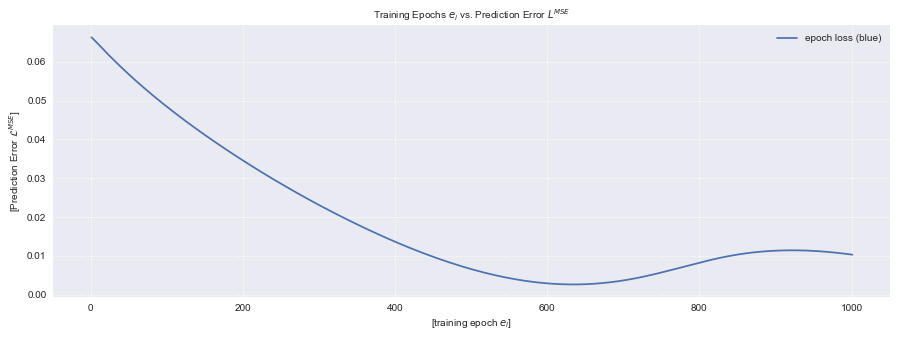

In [100]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' prediction error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel("[training epoch $e_i$]", fontsize=10)
ax.set_ylabel("[Prediction Error $\mathcal{L}^{MSE}$]", fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# add plot title
plt.title('Training Epochs $e_i$ vs. Prediction Error $L^{MSE}$', fontsize=10);

In this section, we will conduct a visual comparison of the predicted daily returns to the actual ('true') daily returns. The comparison will encompass the daily returns of the in-sample time period as well as the returns of the out-of-sample time period.

### 6. Model Import and Validation

In this section, we will **import the trained model** that exhibits the **highest in-sample performance**. In addition, we will use the imported model to determine daily return predictions based on the population of **validation ("out-of-sample") input return** sequences. Finally, we will visualize the daily validation return **predictions** of the trained model in contrast to the validation ("out-of-sample") **target returns**.

#### 6.1. Import Trained Neural Network Model

Before starting our evaluation, let's **import the trained model** that exhibits the **highest in-sample performance** (or any other already trained model we aim to evaluate). Remember, that we stored a checkpoint of all model parameters for  each training epoch to our local model directory. Now, we will load the best performing checkpoint saved (which will hopefully also yield a good out-of-sample performance):

In [101]:
# init the pre-trained model architecture
lstm_model_trained = LSTMNet_Many2One().to(device)

# set the pre-trained model name we aim to load
lstm_model_name_trained = 'https://raw.githubusercontent.com/financial-data-science/CFDS-Notebooks/master/lab_15/models/best_many2one_lstm_model_10000.pth'

# read pretrained model from the remote location
lstm_model_trained_bytes = urllib.request.urlopen(lstm_model_name_trained)

# load tensor from io.BytesIO object
lstm_model_trained_buffer = io.BytesIO(lstm_model_trained_bytes.read())

# load the pre-trained model paramaters 
lstm_model_trained.load_state_dict(torch.load(lstm_model_trained_buffer, map_location=lambda storage, loc: storage))

<All keys matched successfully>

Ok, all keys ("model parameters") matched successfully. This indicates that the trained model was successfully imported into the notebook.

#### 6.2. Derive Model Return Predictions

Next, we will conduct an **out-of-sample** validation of the trained and imported neural network model. Therefore, we will use the **trained model** to determine daily return predictions based on the population of **validation ("out-of-sample") input return** sequences:

In [102]:
# predict sequence output
valid_predictions = lstm_model_trained(valid_sequences_input.to(device))

# collect prediction batch results
valid_predictions_list = valid_predictions.cpu().detach().numpy()[:, -1].tolist()

# collect target batch results
valid_targets_list = (valid_sequences_target).numpy()[:, -1].tolist()

Let's also visualize the daily validation predictions of the trained model in contrast to the **validation ("out-of-sample") target return** sequences:

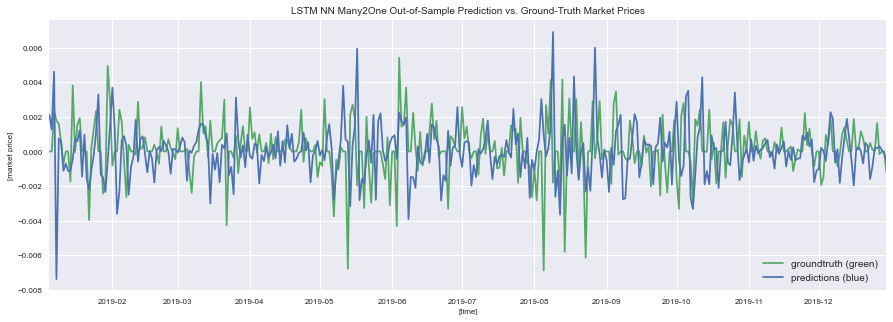

In [103]:
# plot the prediction results
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 5]

fig = plt.figure()
ax = fig.add_subplot(111)

# plot ground-truth out-of-sample returns
ax.plot(valid_stock_sequence_target_date[:, -1], valid_targets_list, color='C1', label='groundtruth (green)')

# plot predicted out-of-sample returns
ax.plot(valid_stock_sequence_target_date[:, -1], valid_predictions_list, color='C0', label='predictions (blue)')

# set x-axis limits
ax.set_xlim(valid_stock_sequence_target_date[:, -1].min(), valid_stock_sequence_target_date[:, -1].max())

# set plot legend
plt.legend(loc="lower right", numpoints=1, fancybox=True)

# set plot title
plt.title('LSTM NN Many2One Out-of-Sample Prediction vs. Ground-Truth Market Prices', fontsize=10)

# set axis labels
plt.xlabel('[time]', fontsize=8)
plt.ylabel('[market price]', fontsize=8)

# set axis ticks fontsize
plt.xticks(fontsize=8)
plt.yticks(fontsize=8);

### 7. Model Backtest

In this section, we will backtest the python `bt` library. Python `bt` is a flexible, backtest framework that can be used to test quantitative trading strategies. In general, backtesting is the process of testing a strategy over a given data set (more details about the `bt` library can be found via: https://pmorissette.github.io/bt/).

#### 7.1. Derive Model Trade Signals

Next, we will the validation ("out-of-sample") **future return predictions $\hat{r}_{t+1}$** into **trade signals** $\phi(\hat{r}_{t+1})$. Thereby, we will, similarly as above, interpret any positive future return prediction greater or equal a predefined threshold $t$ as a **"long" (buy)** signal, formally denoted by $r_{t+1} \geq t$. Correspondingly, we will interpret any negative future return prediction lower or equal a predefined threshold $-t$, formally denoted by $r_{t+1} \leq -t$ as a **"short" (sell)** signal. Formally, the out-of-sample trading signal are derived according to:

<center>
$
\\
\phi(\hat{r}_{t+1})=
\begin{cases}
1.0 & \textrm{("long signal")}, & for & \hat{r}_{t+1} > t\\
-1.0 & \textrm{("short signal")}, & for & \hat{r}_{t+1} < -t\\
\end{cases}
$
</center>

where $\hat{r}_{t+1}$ denotes a by the model predicted future return at time $t+1$. To achieve this, let's specify the trade signal threshold $t$ as introduced above:

In [104]:
valid_signal_threshold = 0.001

In a following step, let's compute the trade signals $\phi(\hat{r}_{t+1})$ accordingly:

In [105]:
# init and prepare the model signal data 
valid_signal_data = pd.DataFrame(valid_predictions_list, columns=['PREDICTIONS'], index=valid_stock_sequence_target_date[:, -1])

# derive trading signals from model predictions
valid_signal_data['SIGNAL'] = np.where(valid_signal_data['PREDICTIONS'] >= valid_signal_threshold, 1.0, 0.0)
valid_signal_data['SIGNAL'] = np.where(valid_signal_data['PREDICTIONS'] <= -valid_signal_threshold, -1.0, valid_signal_data['SIGNAL'])

# offset the signal data
valid_signal_data = valid_signal_data.set_index(valid_signal_data['SIGNAL'].index - pd.DateOffset(1))

Let's inspect the top 10 rows of the prepared and offset trade signals:

In [106]:
valid_signal_data.head(10)

,PREDICTIONS,SIGNAL
2019-01-04,0.002110,1.0
2019-01-05,0.001269,1.0
2019-01-06,0.004618,1.0
2019-01-07,-0.007389,-1.0
2019-01-08,0.000743,0.0
2019-01-09,0.000585,0.0
2019-01-10,-0.001123,-1.0
2019-01-11,-0.000706,0.0
2019-01-12,-0.001129,-1.0
2019-01-13,-0.001120,-1.0


Finally, let's also **visually inspect the trade signals** derived from the model's out-of-sample return predictions:

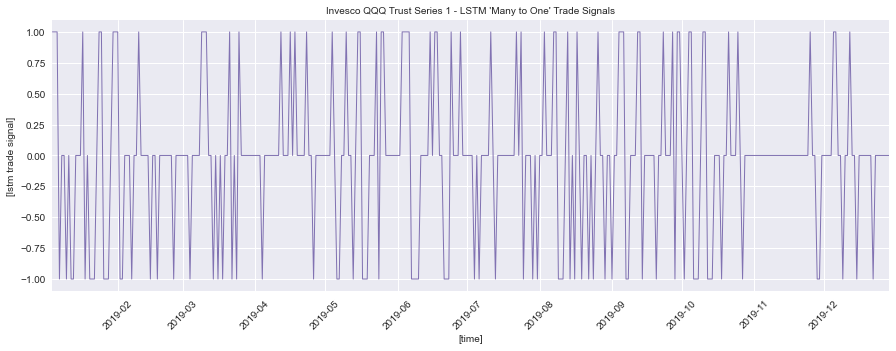

In [107]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(valid_signal_data['SIGNAL'], lw=1.0, color='C3', label='LSTM trade signals')
    
# set axis ranges
ax.set_xlim([valid_signal_data.index[0], valid_signal_data.index[-1]])
ax.set_ylim([-1.1, 1.1])

# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[lstm trade signal]', fontsize=10)

# rotate x-axis ticks
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set plot title
plt.title('Invesco QQQ Trust Series 1 - LSTM \'Many to One\' Trade Signals', fontsize=10);

Upon successful trade signal generation, let's determine the number of signal changes (trades to be executed) within the out-of-sample timeframe **03/2016** until **12/2017**, corresponding to a total in-sample timeframe of approx. **21 months** (9 + 12):

In [108]:
# determine number of signal changes
len(list(itertools.groupby(valid_signal_data['SIGNAL'], lambda x: x > 0)))

84

On average around **7** signal changes (trades) per month (148 signal changes / 21 months) within the out-of-sample time period.

#### 7.2. Prepare Backtest Market Data

Now, let's prepare and trim the validation ("out-of-sample") market data of QQQ so that it can be utilized by the `bt` backtesting library:

In [109]:
valid_stock_market_data = pd.DataFrame(stock_data_price['QQQ'])
valid_stock_market_data = valid_stock_market_data.rename(columns={'QQQ': 'PRICE'})
valid_stock_market_data = valid_stock_market_data.set_index(pd.to_datetime(stock_data_price.index))

Let's inspect the top 5 rows of the prepared validation QQQ market data:

In [110]:
valid_stock_market_data.head(5)

,PRICE
2010-01-04,41.570904
2010-01-05,41.570904
2010-01-06,41.320183
2010-01-07,41.347046
2010-01-08,41.687347


Trim the prepared market data to the out-of-sample time period:

In [111]:
valid_stock_market_data = valid_stock_market_data[valid_stock_market_data.index >= valid_signal_data.index[0]]
valid_stock_market_data = valid_stock_market_data[valid_stock_market_data.index <= valid_signal_data.index[-1]]

Visualize the trimmed validation ("out-of-sample") market data:

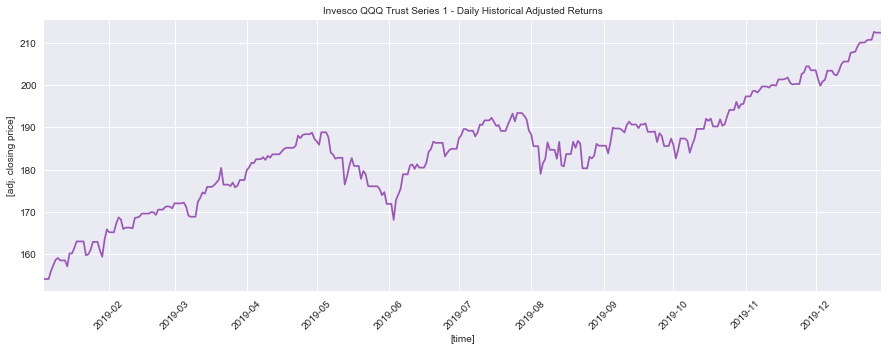

In [112]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot the valiation market data
ax.plot(valid_stock_market_data['PRICE'], color='#9b59b6')
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_ylabel('[QQQ closing price]', fontsize=10)

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

# set axis labels and limits
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim([valid_stock_market_data.index[0], valid_stock_market_data.index[-1]])
ax.set_ylabel('[adj. closing price]', fontsize=10)

# set plot title
plt.title('Invesco QQQ Trust Series 1 - Daily Historical Adjusted Returns', fontsize=10);

Finally let's calculate the total return gained by following a simple **"buy and hold"** strategy in the out-of-sample time period:

In [113]:
np.abs(valid_stock_market_data.iloc[0]['PRICE'] - valid_stock_market_data.iloc[-1]['PRICE']) / valid_stock_market_data.iloc[0]['PRICE']

0.37854650376850146

Ok, with such a simple strategy we would have been able to yield a total return of approx. **37.85%**.

#### 7.3. Prepare Model Backtest Strategy and Backtest

Now that we have prepared (i) the **validation trading signals** as well as (ii) the **validation market data** let's implement, similarly as already done above, the LSTM based trading strategy for the **out-of-sample time period**. We will name the strategy to be implemented `LSTMStrategyValid`:

In [114]:
class LSTMStrategyValid(bt.Algo):
    
    def __init__(self, signals):
        
        # set class signals
        self.signals = signals
        
    def __call__(self, target):
        
        if target.now in self.signals.index[1:]:
            
            # get actual signal
            signal = self.signals[target.now]
            
            # set target weights according to signal
            target.temp['weights'] = dict(PRICE=signal)
            
        # return True since we want to move on to the next timestep
        return True

Let's instantiate the **LSTM based trading strategy** of the out-of-sample time period using the prepared trade signals (`valid_signal_data`) of the model:

In [115]:
lstm_strategy = bt.Strategy('lstm', [bt.algos.SelectAll(), LSTMStrategy(valid_signal_data['SIGNAL']), bt.algos.Rebalance()])

Next, we will **initialize the backtest** using both (i) the strategy and (ii) prepared out-of-sample market data (`valid_stock_market_data`):

In [116]:
backtest_lstm = bt.Backtest(strategy=lstm_strategy, data=valid_stock_market_data, name='stock_lstm_backtest')

In addition, let's also prepare trade signals of a **"baseline" buy-and-hold trading strategy** for comparison purposes. Our buy-and-hold strategy sends a "long" (+1.0) signal at each time step of the out-of-sample time frame: 

In [117]:
# copy the lstm signal data
valid_signal_data_base = valid_signal_data.copy(deep=True) 

# reset all trade signals to 1 "long"
valid_signal_data_base['SIGNAL'] = 1.0

Let's instantiate the **baseline trading strategy** of the out-of-sample time period using the prepared baseline trade signals `valid_signal_data_base`:

In [118]:
# init the baseline trading strategy
base_strategy = bt.Strategy('baseline', [bt.algos.SelectAll(), LSTMStrategy(valid_signal_data_base['SIGNAL']), bt.algos.Rebalance()])

Next, we will **initialize the backtest** using both (i) the baseline strategy and (ii) prepared out-of-sample market data (`valid_stock_market_data`):

In [119]:
# init the baseline backtest
backtest_base = bt.Backtest(strategy=base_strategy, data=valid_stock_market_data, name='stock_base_backtest')

#### 7.4. Evaluate Backtest Results

Upon successful preparation of both backtests, let's run the backtests for each trading strategy: 

In [120]:
backtest_results = bt.run(backtest_lstm, backtest_base)

stock_lstm_backtest
0% [############################# ] 100% | ETA: 00:00:00stock_base_backtest
0% [############################# ] 100% | ETA: 00:00:00

Ok, that went smooth. Let's now inspect and compare the individual backtest results and performance measures respectively. To print the backtest results inside of the notebook we will make use of the `display()` function provided by the `bt` library:

In [121]:
backtest_results.display()

Stat                 stock_lstm_backtest    stock_base_backtest
-------------------  ---------------------  ---------------------
Start                2019-01-03             2019-01-03
End                  2019-12-29             2019-12-29
Risk-free rate       0.00%                  0.00%

Total Return         18.13%                 37.85%
Daily Sharpe         1.40                   1.82
Daily Sortino        2.46                   2.84
CAGR                 18.41%                 38.50%
Max Drawdown         -3.58%                 -10.98%
Calmar Ratio         5.15                   3.51

MTD                  0.20%                  4.37%
3m                   -1.09%                 14.46%
6m                   2.89%                  14.87%
YTD                  18.13%                 37.85%
1Y                   -                      -
3Y (ann.)            -                      -
5Y (ann.)            -                      -
10Y (ann.)           -                      -
Since Incep. (ann.) 

In addition, we collect the **detailed backtest performance** per timestep of the LSTM trading strategy:

In [122]:
backtest_lstm_details = backtest_lstm.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_lstm_details['Abs. EQUITY'] = backtest_lstm.strategy.values # equity per timestep
backtest_lstm_details['CASH'] = backtest_lstm.strategy.cash # cash per timestep

Let's inspect the first 10 rows of the LSTM trading strategy backtest details:

In [123]:
backtest_lstm_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH
2019-01-03,100.000000,1.000000e+06,1.000000e+06
2019-01-04,100.000000,1.000000e+06,1.000000e+06
2019-01-05,100.000000,1.000000e+06,4.772415e+01
2019-01-06,100.000000,1.000000e+06,4.772415e+01
2019-01-07,101.190494,1.011905e+06,2.023918e+06
2019-01-08,100.275072,1.002751e+06,1.002751e+06
2019-01-09,100.275072,1.002751e+06,1.002751e+06
2019-01-10,100.275072,1.002751e+06,2.005600e+06
2019-01-11,100.641946,1.006419e+06,1.006419e+06
2019-01-12,100.641946,1.006419e+06,2.012890e+06


Furthermore, let's visualize the **monthly returns** obtained by the LSTM based trading strategy:

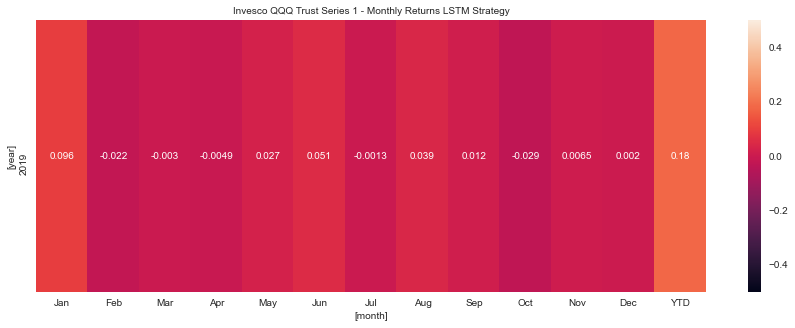

In [124]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(backtest_lstm.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('Invesco QQQ Trust Series 1 - Monthly Returns LSTM Strategy', fontsize=10);

We also collect the **detailed backtest performance per timestep** of the baseline "buy-and-hold" trading strategy:

In [125]:
backtest_base_details = backtest_base.strategy.prices.to_frame(name='Rel. EQUITY')
backtest_base_details['Abs. EQUITY'] = backtest_base.strategy.values # equity per timestep
backtest_base_details['CASH'] = backtest_base.strategy.cash # cash per timestep

Let's inspect the first 10 rows of the "buy-and-hold" trading strategy backtest details:

In [126]:
backtest_base_details.head(10)

,Rel. EQUITY,Abs. EQUITY,CASH
2019-01-03,100.000000,1.000000e+06,1000000.000000
2019-01-04,100.000000,1.000000e+06,1000000.000000
2019-01-05,100.000000,1.000000e+06,47.724152
2019-01-06,100.000000,1.000000e+06,47.724152
2019-01-07,101.190494,1.011905e+06,47.724152
2019-01-08,102.105774,1.021058e+06,47.724152
2019-01-09,102.937850,1.029378e+06,47.724152
2019-01-10,103.232255,1.032323e+06,47.724152
2019-01-11,102.854616,1.028546e+06,47.724152
2019-01-12,102.854616,1.028546e+06,47.724152


Furthermore, let's visualize the **monthly returns** obtained by the "buy-and-hold" trading strategy:

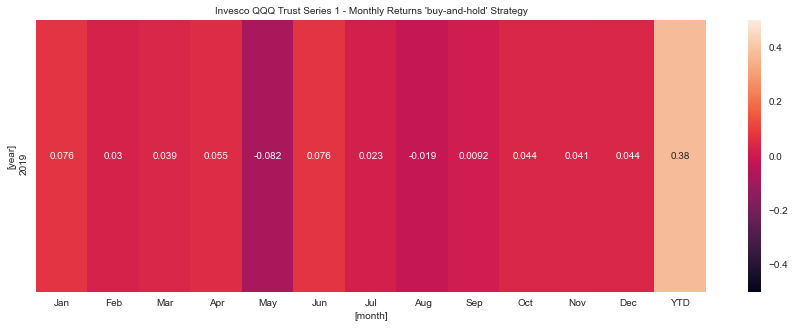

In [127]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot heatmap of monthly returns generated by the strategy
ax = sns.heatmap(backtest_base.stats.return_table, annot=True, cbar=True, vmin=-0.5, vmax=0.5)

# set axis labels
ax.set_xlabel('[month]', fontsize=10)
ax.set_ylabel('[year]', fontsize=10)

# set plot title
ax.set_title('Invesco QQQ Trust Series 1 - Monthly Returns \'buy-and-hold\' Strategy', fontsize=10);

Finally, let's also visually compare the **equity progression** of both trading 'strategies over time:

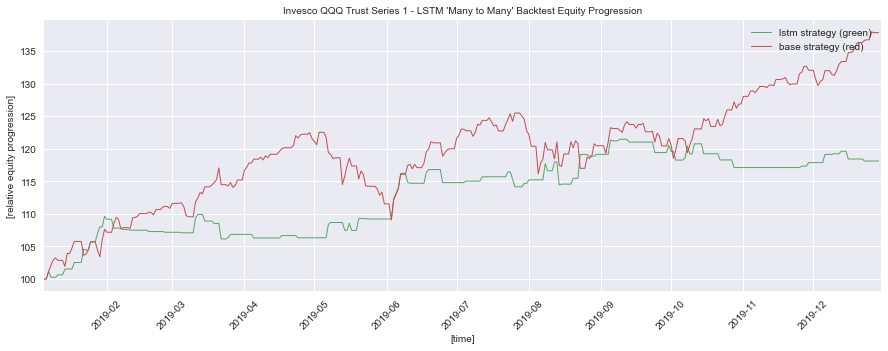

In [128]:
plt.rcParams['figure.figsize'] = [15, 5]
fig = plt.figure()
ax = fig.add_subplot(111)

# plot lstm strategy equity progression 
ax.plot(backtest_lstm_details['Rel. EQUITY'], color='C1',lw=1.0, label='lstm strategy (green)')

# plot baseline strategy equity progression
ax.plot(backtest_base_details['Rel. EQUITY'], color='C2',lw=1.0, label='base strategy (red)')

# rotate x-tick labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
# set axis labels
ax.set_xlabel('[time]', fontsize=10)
ax.set_xlim(valid_stock_sequence_target_date[:, -1].min(), valid_stock_sequence_target_date[:, -1].max())
ax.set_ylabel('[relative equity progression]', fontsize=10)

# set plot legend
plt.legend(loc="upper right", numpoints=1, fancybox=True)

# set plot title
plt.title('Invesco QQQ Trust Series 1 - LSTM \'Many to Many\' Backtest Equity Progression', fontsize=10);

### Exercises:

We recommend you to try the following exercises as part of the lab:

**1. Evaluation of Shallow vs. Deep RNN Models.**

> Download the daily closing prices of the Invesco QQQ within the time frame starting from 01/01/1990 until 12/31/2019. In addition to the architecture of the lab notebook, evaluate further (more shallow as well as more deep) RNN architectures by either: **(1) re-moving/adding layers of LSTM cells**, and/or **(2) increasing/decreasing the dimensionality of the LSTM cells hidden state**. Train your model (using architectures you selected) for at least 20'000 training epochs but keep the following parameters unchanged (a) sequence length: 5 time-steps (days) and (b) train vs. test fraction: 0.9.

> Analyze the prediction performance of the trained models in terms of training time and prediction accuracy. Furthermore, backtest the out-of-sample signals predicted by each of your models and evaluate them in terms of total return and equity progression. Which of your architecture results in the best performing model, and why?

In [129]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

**2. Training and Evaluation of Models Learned from Additional Stocks.**

> Download the daily closing prices of at least **two additional NASDAQ stocks** (e.g., Alphabet, Facebook) within the time frame starting from 01/01/1990 until 12/31/2017. Pls. select two stocks that you are interested in to investigate (e.g. stocks that you may occasionally trade yourself). Learn an ’optimal’ **many-to-one RNN model** of both stocks and backtest their corresponding trade signals by following the approach outlined in the lab notebook regarding the QQQ. Pls. keep the train vs. test dataset fraction fixed to 0.9, all other parameters of the data preparation and model training can be changed.

> Analyse the performance of the learned models in terms of their prediction accuracy as well as their out-of-sample backtest performance (e. g. the total return and equity progression). What architectures and corresponding training parameters result in the best performing models?

In [130]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************

### Lab Summary:

In this lab, a step by step introduction into **design, implementation, training and evaluation** of a LSTM neural network based trading strategy is presented. In addition to the previous "one-to-one" training setup, a "many-to-one" training setup is introduced that allows to learn pattern or features across distinct input time series.

The strategy trades a specific financial instrument based on its historical market prices. The degree of success of the implemented strategy is evaluated based in its backtest performance with particular focus on (1) the strategy's **total return** as well as (2) its **equity progression** over time. The code provided in this lab may provides a blueprint for the development and testing of more complex trading strategies.

You may want to execute the content of your lab outside of the Jupyter notebook environment, e.g. on a compute node or a server. The cell below converts the lab notebook into a standalone and executable python script. Pls. note that to convert the notebook, you need to install Python's **nbconvert** library and its extensions:

In [131]:
# installing the nbconvert library
!pip3 install nbconvert
!pip3 install jupyter_contrib_nbextensions

Let's now convert the Jupyter notebook into a plain Python script:

In [132]:
!jupyter nbconvert --to script cfds_lab_15.ipynb

[NbConvertApp] Converting notebook cfds_lab_15.ipynb to script
[NbConvertApp] Writing 77043 bytes to cfds_lab_15.py
